In [ ]:
# %% [markdown]
# # Data Science Salaries — полный пайплайн (структурировано, по одной ячейке)
# Последовательность:
# 1) Подготовка окружения и вспомогательные функции
# 2) Загрузка данных через kagglehub (оставлено без изменений)
# 3) EDA: распределение + boxplot + текстовая сводка
# 4) Очистка/удаление выбросов (IQR)
# 5) Feature Engineering
# 6) Трейн/тест сплит + препроцессор
# 7) Linear Regression (база)
# 8) Random Forest (GridSearchCV)
# 9) XGBoost (GridSearchCV)
# 10) CatBoost (фиксированные «оптимизированные» параметры)
# 11) Важность признаков CatBoost (топ-15) — показываем и сохраняем
# 12) Взаимодействия топ-фичей (box/scatter) — сохраняем и показываем
# 13) Анализ остатков CatBoost — сохраняем и показываем
# 14) Ошибки по категориям + сводные ошибки
# 15) Топ-10 абсолютных ошибок (печать и csv)
# 16) Сохранение модели CatBoost
# 17) Сводка метрик всех моделей + барчарты (сохраняем/показываем)
# 18) CatBoost: original vs embeddings (TF-IDF+Word2Vec) + сравнение (по желанию)

In [ ]:
!pip install catboost

In [ ]:
!pip install gensim

In [ ]:
# %%
# 1) Подготовка окружения и вспомогательные функции
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
from gensim.models import Word2Vec
import joblib

In [ ]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 7)

ROOT = Path().resolve()
FIG_DIR = ROOT / "figures"
ARTIFACTS_DIR = ROOT / "artifacts"
FIG_DIR.mkdir(parents=True, exist_ok=True)
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42

def save_and_show(filepath: Path):
    """Сохраняет текущий график и показывает его."""
    plt.tight_layout()
    plt.savefig(filepath, dpi=150, bbox_inches="tight")
    plt.show()

def evaluate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

def print_metrics(title, mae, rmse, r2):
    print(f"\n[{title}]")
    print(f" MAE : {mae:,.2f}")
    print(f" RMSE: {rmse:,.2f}")
    print(f" R²  : {r2:,.4f}")

def ensure_column(df: pd.DataFrame, col: str, default):
    if col not in df.columns:
        df[col] = default

def simplify_job_title(title: str) -> str:
    t = str(title).lower()
    if "scientist" in t or "research" in t: return "Data Scientist"
    if "engineer"  in t or "architect" in t: return "Data Engineer"
    if "analyst"   in t or "bi" in t:        return "Data Analyst"
    if "ml" in t or "machine learning" in t or "ai" in t: return "ML Engineer"
    return "Other"

def simplify_country(country: str) -> str:
    c = str(country)
    if c == "United States": return "USA"
    if c in ["Canada","United Kingdom","Australia","Germany","France"]: return "Developed"
    return "Other"

def catboost_feature_importance(model: CatBoostRegressor, top_n=15, title="Важные признаки", fname="feature_importance.png"):
    imp = model.get_feature_importance()
    names = model.feature_names_
    df_imp = pd.DataFrame({"Feature": names, "Importance": imp}).sort_values("Importance", ascending=False)
    print("\nТоп важных признаков:")
    print(df_imp.head(top_n).to_string(index=False))
    plt.figure(figsize=(12, 7))
    sns.barplot(data=df_imp.head(top_n), x="Importance", y="Feature")
    plt.title(title)
    save_and_show(FIG_DIR / fname)
    return df_imp

In [ ]:
# 2) Загрузка данных через kagglehub
import pandas as pd
import kagglehub

# Скачиваем датасет с Kaggle
path = kagglehub.dataset_download("sazidthe1/data-science-salaries")
print("Path to dataset files:", path)

# Загружаем CSV в DataFrame
df = pd.read_csv(f"{path}/data_science_salaries.csv")

# Приводим нужные колонки к числовому типу
df['work_year'] = pd.to_numeric(df['work_year'], errors='coerce')
df['salary'] = pd.to_numeric(df['salary'], errors='coerce')
df['salary_in_usd'] = pd.to_numeric(df['salary_in_usd'], errors='coerce')

# Проверяем
print(df.info())
print(df.head())


Using Colab cache for faster access to the 'data-science-salaries' dataset.
Path to dataset files: /kaggle/input/data-science-salaries
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6599 entries, 0 to 6598
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   job_title           6599 non-null   object
 1   experience_level    6599 non-null   object
 2   employment_type     6599 non-null   object
 3   work_models         6599 non-null   object
 4   work_year           6599 non-null   int64 
 5   employee_residence  6599 non-null   object
 6   salary              6599 non-null   int64 
 7   salary_currency     6599 non-null   object
 8   salary_in_usd       6599 non-null   int64 
 9   company_location    6599 non-null   object
 10  company_size        6599 non-null   object
dtypes: int64(3), object(8)
memory usage: 567.2+ KB
None
        job_title experience_level employment_type work_models  work_year  \


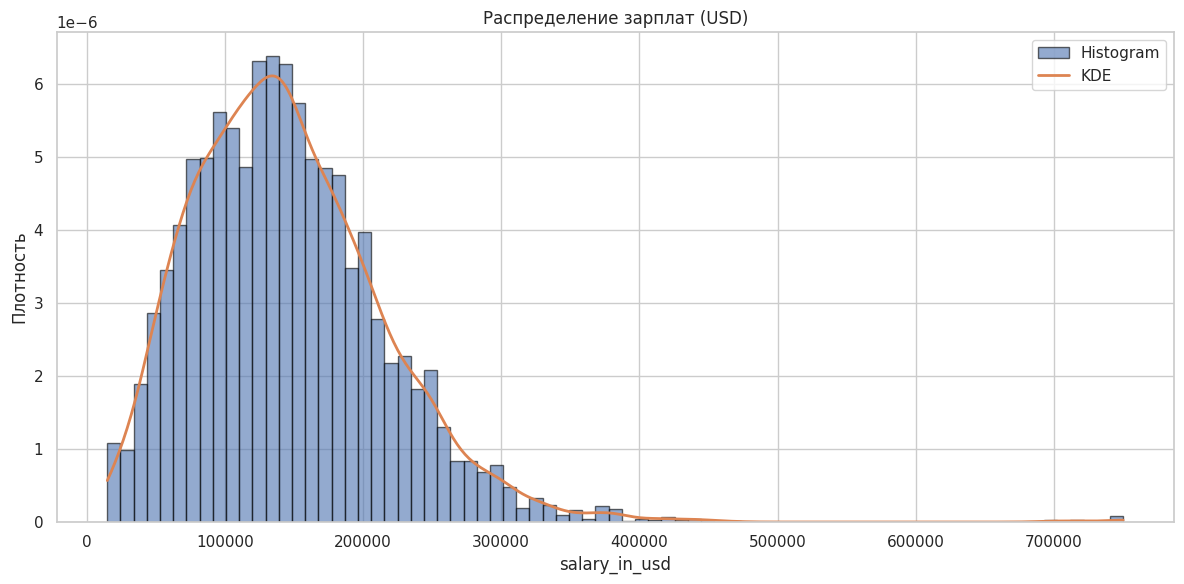

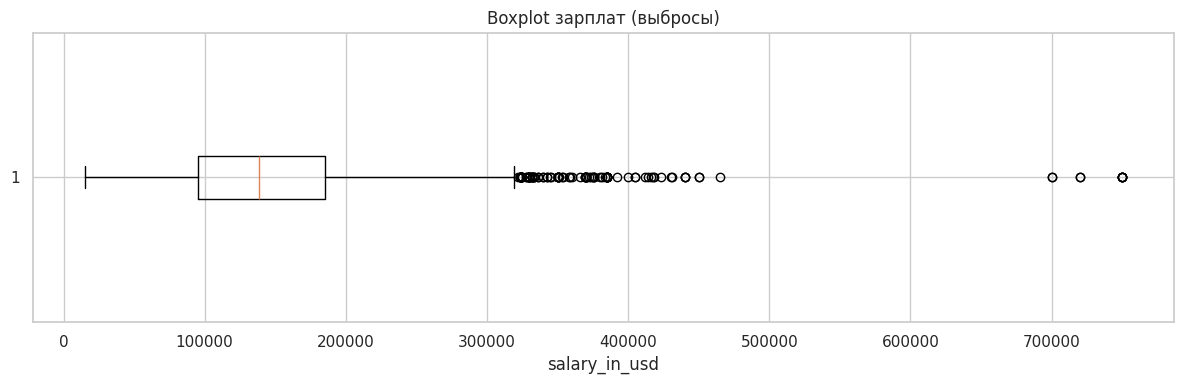


Размерность датасета: (6599, 11)
Годы (min..max): 2020 … 2024
Зарплата (USD) — описательная статистика:
count      6599.00
mean     145560.56
std       70946.84
min       15000.00
10%       63520.00
25%       95000.00
50%      138666.00
75%      185000.00
90%      235000.00
max      750000.00


In [ ]:
# 3) EDA: распределение и boxplot + текстовая сводка (устойчиво ко всем версиям)
# Без seaborn.kdeplot, чтобы избежать ValueError на новых pandas/matplotlib

# 3.1 Подготовка данных
salary_series = pd.to_numeric(df["salary_in_usd"], errors="coerce").dropna()
salary_np = salary_series.to_numpy()

# 3.2 Гистограмма + KDE (scipy, а если её нет — ручной Gaussian KDE)
def kde_manual(samples: np.ndarray, xs: np.ndarray, bandwidth: float | None = None) -> np.ndarray:
    samples = np.asarray(samples, dtype=float)
    n = samples.size
    # Silverman's rule of thumb
    std = np.std(samples)
    iqr = np.subtract(*np.percentile(samples, [75, 25]))
    sigma = min(std, iqr / 1.349) if iqr > 0 else std
    h = (0.9 * sigma * n ** (-1/5)) if (bandwidth is None) else bandwidth
    if not np.isfinite(h) or h <= 0:
        h = 1.0
    diffs = (xs[:, None] - samples[None, :]) / h
    dens = np.exp(-0.5 * diffs**2) / (np.sqrt(2*np.pi) * h)
    return dens.mean(axis=1)

xs = np.linspace(salary_np.min(), salary_np.max(), 512)

plt.figure(figsize=(12, 6))
# Гистограмма через matplotlib (без seaborn, чтобы исключить баг индексов)
plt.hist(salary_np, bins="auto", density=True, alpha=0.6, edgecolor="black", label="Histogram")

# Пытаемся использовать scipy, если установлена
kde_y = None
try:
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(salary_np)
    kde_y = kde(xs)
except Exception:
    # Фоллбек — ручная оценка KDE
    kde_y = kde_manual(salary_np, xs)

plt.plot(xs, kde_y, linewidth=2, label="KDE")
plt.title("Распределение зарплат (USD)")
plt.xlabel("salary_in_usd"); plt.ylabel("Плотность")
plt.legend()
save_and_show(FIG_DIR / "salary_distribution.png")

# 3.3 Boxplot (через matplotlib, чтобы вообще не трогать seaborn здесь)
plt.figure(figsize=(12, 4))
plt.boxplot(salary_np, vert=False, showfliers=True)
plt.title("Boxplot зарплат (выбросы)")
plt.xlabel("salary_in_usd")
save_and_show(FIG_DIR / "salary_boxplot.png")

# 3.4 Текстовая сводка
print("\nРазмерность датасета:", df.shape)

years = pd.to_numeric(df["work_year"], errors="coerce")
ymin, ymax = years.min(), years.max()
ymin_txt = "n/a" if pd.isna(ymin) else int(ymin)
ymax_txt = "n/a" if pd.isna(ymax) else int(ymax)
print("Годы (min..max):", ymin_txt, "…", ymax_txt)

desc = pd.Series(salary_np, name="salary_in_usd").describe(percentiles=[.1,.25,.5,.75,.9]).round(2)
print("Зарплата (USD) — описательная статистика:")
print(desc.to_string())


In [ ]:
# 4) Очистка / удаление выбросов (IQR)
def remove_outliers_iqr(d: pd.DataFrame, column: str) -> pd.DataFrame:
    q1, q3 = d[column].quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return d[(d[column] >= lo) & (d[column] <= hi)]

df_clean = df.copy()
if "salary" in df_clean.columns: df_clean = df_clean.drop(columns=["salary"])
if "salary_currency" in df_clean.columns: df_clean = df_clean.drop(columns=["salary_currency"])
n_before = len(df_clean)
df_clean = remove_outliers_iqr(df_clean, "salary_in_usd")
n_after = len(df_clean)
print(f"\nУдаление выбросов (IQR): осталось {n_after} записей (удалено {n_before - n_after}).")



Удаление выбросов (IQR): осталось 6492 записей (удалено 107).



Удаление выбросов (IQR): осталось 6492 записей (удалено 107).


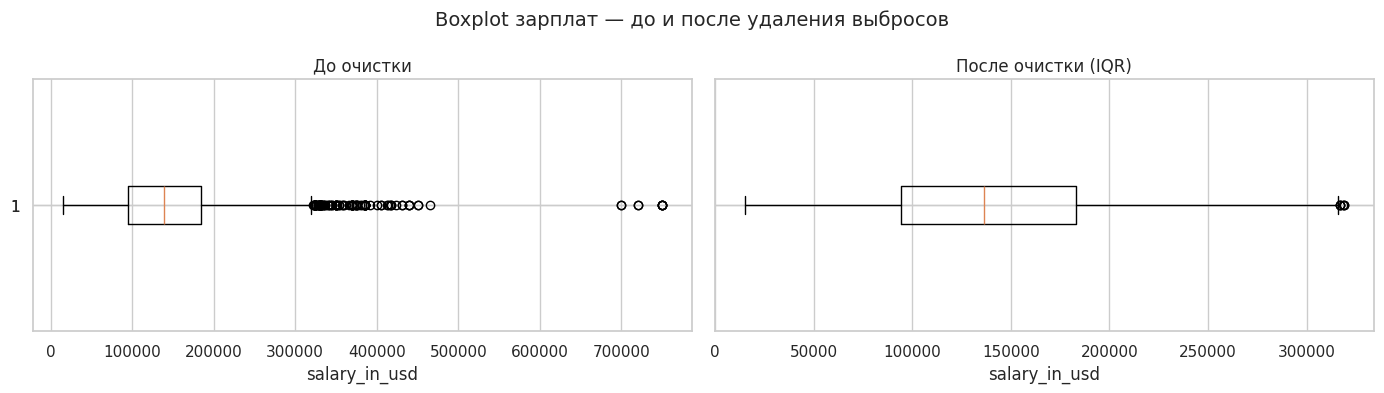

In [ ]:
# 4) Очистка / удаление выбросов (IQR) + графики "до" и "после"
def remove_outliers_iqr(d: pd.DataFrame, column: str) -> pd.DataFrame:
    q1, q3 = d[column].quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return d[(d[column] >= lo) & (d[column] <= hi)]

df_clean = df.copy()
if "salary" in df_clean.columns:
    df_clean = df_clean.drop(columns=["salary"])
if "salary_currency" in df_clean.columns:
    df_clean = df_clean.drop(columns=["salary_currency"])

n_before = len(df_clean)
df_clean = remove_outliers_iqr(df_clean, "salary_in_usd")
n_after = len(df_clean)

print(f"\nУдаление выбросов (IQR): осталось {n_after} записей (удалено {n_before - n_after}).")

# --- Визуализация ДО/ПОСЛЕ ---
salary_before = pd.to_numeric(df["salary_in_usd"], errors="coerce").dropna().to_numpy()
salary_after = pd.to_numeric(df_clean["salary_in_usd"], errors="coerce").dropna().to_numpy()

# Гистограммы рядом
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
axes[0].hist(salary_before, bins="auto", color="skyblue", edgecolor="black")
axes[0].set_title("До очистки")
axes[0].set_xlabel("salary_in_usd"); axes[0].set_ylabel("Количество")

axes[1].hist(salary_after, bins="auto", color="seagreen", edgecolor="black")
axes[1].set_title("После очистки (IQR)")
axes[1].set_xlabel("salary_in_usd")

fig.suptitle("Распределение зарплат — до и после удаления выбросов", fontsize=14)
save_and_show(FIG_DIR / "salary_distribution_before_after.png")

# Boxplot до/после
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
axes[0].boxplot(salary_before, vert=False, showfliers=True)
axes[0].set_title("До очистки")
axes[0].set_xlabel("salary_in_usd")

axes[1].boxplot(salary_after, vert=False, showfliers=True)
axes[1].set_title("После очистки (IQR)")
axes[1].set_xlabel("salary_in_usd")

fig.suptitle("Boxplot зарплат — до и после удаления выбросов", fontsize=14)
save_and_show(FIG_DIR / "salary_boxplot_before_after.png")



[Feature Engineering] Созданы признаки:
 simplified_job_title, is_usa_residence, is_usa_company, experience_years,
 exp_level_size, simplified_residence, simplified_company_loc

Распределение simplified_job_title:
simplified_job_title
Data Engineer     2784
Data Scientist    1892
Data Analyst      1161
Other              612
ML Engineer         43

Распределение experience_level:
experience_level
Senior-level       4032
Mid-level          1657
Entry-level         564
Executive-level     239


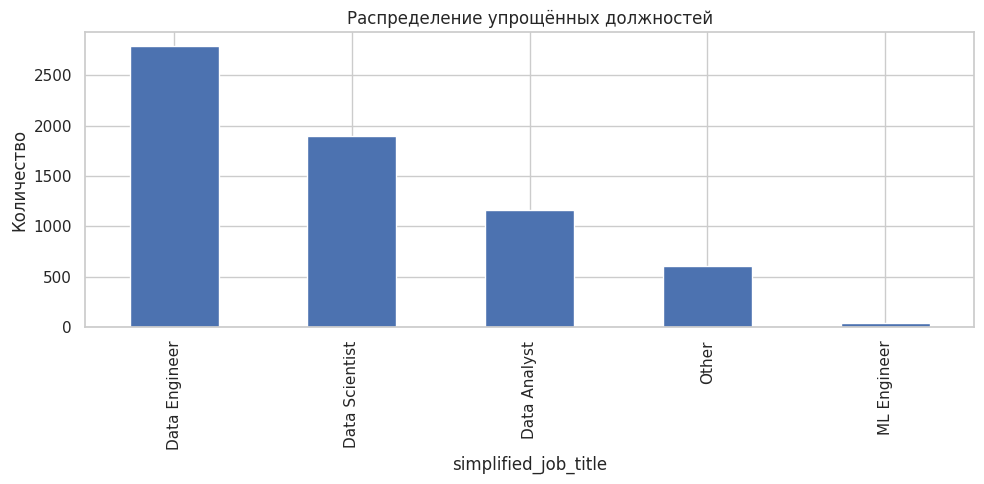


Итоговые формы данных после FE:
 X: (6492, 14)  y: (6492,)


In [ ]:
# 5) Feature Engineering (упрощённые должности, опыт, страны, взаимодействия) + сводки и графики
# Вход: df_clean из шага #4
def simplify_job_title(title: str) -> str:
    t = str(title).lower()
    if "scientist" in t or "research" in t: return "Data Scientist"
    if "engineer"  in t or "architect" in t: return "Data Engineer"
    if "analyst"   in t or "bi" in t:        return "Data Analyst"
    if "ml" in t or "machine learning" in t or "ai" in t: return "ML Engineer"
    return "Other"

def simplify_country(country: str) -> str:
    c = str(country)
    if c == "United States": return "USA"
    if c in ["Canada","United Kingdom","Australia","Germany","France"]: return "Developed"
    return "Other"

def ensure_column(df: pd.DataFrame, col: str, default):
    if col not in df.columns:
        df[col] = default

# Совместимость: если нет work_models — добавим
ensure_column(df_clean, "work_models", "unknown")

# 5.1 Создание новых признаков
df_fe = df_clean.copy()
df_fe["simplified_job_title"] = df_fe["job_title"].apply(simplify_job_title)
df_fe["is_usa_residence"]     = (df_fe["employee_residence"].astype(str) == "United States").astype(int)
df_fe["is_usa_company"]       = (df_fe["company_location"].astype(str)   == "United States").astype(int)
base_year = 2020
df_fe["experience_years"]     = df_fe["work_year"] - base_year
df_fe["exp_level_size"]       = df_fe["experience_level"].astype(str) + "_" + df_fe["company_size"].astype(str)
df_fe["simplified_residence"]    = df_fe["employee_residence"].apply(simplify_country)
df_fe["simplified_company_loc"]  = df_fe["company_location"].apply(simplify_country)

# 5.2 Сводки по новым признакам (важно для контроля)
print("\n[Feature Engineering] Созданы признаки:")
print(" simplified_job_title, is_usa_residence, is_usa_company, experience_years,")
print(" exp_level_size, simplified_residence, simplified_company_loc")

print("\nРаспределение simplified_job_title:")
print(df_fe["simplified_job_title"].value_counts().to_string())

print("\nРаспределение experience_level:")
print(df_fe["experience_level"].value_counts().to_string())

# 5.3 Небольшие графики по новым фичам (и сохранить, и показать)
# Барчарт по упрощённым должностям
plt.figure(figsize=(10, 5))
df_fe["simplified_job_title"].value_counts().plot(kind="bar")
plt.title("Распределение упрощённых должностей")
plt.xlabel("simplified_job_title"); plt.ylabel("Количество")
save_and_show(FIG_DIR / "fe_simplified_job_title_counts.png")

# Boxplot: зарплата по simplified_job_title
plt.figure(figsize=(12, 6))
sns.boxplot(x="simplified_job_title", y="salary_in_usd", data=df_fe)
plt.title("Зарплата по упрощённым должностям")
plt.xticks(rotation=30)
save_and_show(FIG_DIR / "fe_salary_by_simplified_job_title.png")

# 5.4 Определяем наборы фичей для следующих шагов (моделирование)
categorical_features = [
    "simplified_job_title","experience_level","employment_type","work_models",
    "employee_residence","company_location","company_size",
    "simplified_residence","simplified_company_loc","exp_level_size"
]
numerical_features = ["work_year","experience_years","is_usa_residence","is_usa_company"]
target = "salary_in_usd"

# Проверим наличие всех колонок (на случай отличий версий датасета)
missing_cat = [c for c in categorical_features if c not in df_fe.columns]
missing_num = [c for c in numerical_features if c not in df_fe.columns]
if missing_cat or missing_num:
    print("\n[Предупреждение] Отсутствующие колонки:")
    if missing_cat: print("  Категориальные:", missing_cat)
    if missing_num: print("  Числовые:", missing_num)

# Итоговые X, y (для следующих ячеек — сплит, препроцессор, модели)
X = df_fe[[c for c in categorical_features if c in df_fe.columns] + [c for c in numerical_features if c in df_fe.columns]].copy()
y = df_fe[target].copy()

print("\nИтоговые формы данных после FE:")
print(" X:", X.shape, " y:", y.shape)


In [ ]:
# 6) Трейн/тест сплит + препроцессор (OneHot для категорий, скейлер для числовых)

# Разделяем выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Определяем типы признаков из X (после FE)
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

# Совместимость со sklearn разных версий:
# - в новых: OneHotEncoder(sparse_output=False)
# - в старых: OneHotEncoder(sparse=False)
from inspect import signature
ohe_kwargs = {"handle_unknown": "ignore"}
if "sparse_output" in signature(OneHotEncoder).parameters:
    ohe_kwargs["sparse_output"] = False
else:
    ohe_kwargs["sparse"] = False

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(**ohe_kwargs), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop"
)

# Печать текстовой диагностики
print("\n[Split]")
print(f" Train shape: X={X_train.shape}, y={y_train.shape}")
print(f" Test  shape: X={X_test.shape}, y={y_test.shape}")

print("\n[Features]")
print(f" Категориальные ({len(cat_cols)}): {cat_cols}")
print(f" Числовые       ({len(num_cols)}): {num_cols}")

# Оценим размерность после препроцессинга (ТОЛЬКО на трейне)
# Важно: это не влияет на модели — просто информативно
Xt_preview = preprocessor.fit_transform(X_train.copy())
print(f"\nПосле препроцессинга (только train): shape = {Xt_preview.shape}")
print("Препроцессор готов. Далее — обучение моделей.")



[Split]
 Train shape: X=(5193, 14), y=(5193,)
 Test  shape: X=(1299, 14), y=(1299,)

[Features]
 Категориальные (10): ['simplified_job_title', 'experience_level', 'employment_type', 'work_models', 'employee_residence', 'company_location', 'company_size', 'simplified_residence', 'simplified_company_loc', 'exp_level_size']
 Числовые       (4): ['work_year', 'experience_years', 'is_usa_residence', 'is_usa_company']

После препроцессинга (только train): shape = (5193, 185)
Препроцессор готов. Далее — обучение моделей.


In [ ]:
# 7) Linear Regression — базовый ориентир

# Собираем пайплайн: препроцессор + линейная регрессия
pipe_lr = Pipeline([
    ("pre", preprocessor),
    ("reg", LinearRegression())
])

# Обучаем модель
pipe_lr.fit(X_train, y_train)

# Предсказания на тесте
pred_lr = pipe_lr.predict(X_test)

# Метрики
mae_lr, rmse_lr, r2_lr = evaluate_metrics(y_test, pred_lr)

print_metrics("Linear Regression", mae_lr, rmse_lr, r2_lr)




[Linear Regression]
 MAE : 40,323.72
 RMSE: 50,722.43
 R²  : 0.3497


In [ ]:
# 8) Random Forest — подбор параметров через GridSearchCV

pipe_rf = Pipeline([
    ("pre", preprocessor),
    ("reg", RandomForestRegressor(
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

# Сетка параметров
rf_grid = {
    "reg__n_estimators": [200, 400],
    "reg__max_depth": [None, 12, 20],
    "reg__min_samples_split": [2, 5],
}

# GridSearchCV
gs_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=rf_grid,
    cv=3,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)

# Обучаем
gs_rf.fit(X_train, y_train)

# Лучшие параметры
print("\nЛучшие параметры Random Forest:", gs_rf.best_params_)

# Предсказания
pred_rf = gs_rf.best_estimator_.predict(X_test)

# Метрики
mae_rf, rmse_rf, r2_rf = evaluate_metrics(y_test, pred_rf)
print_metrics("Random Forest (tuned)", mae_rf, rmse_rf, r2_rf)


Fitting 3 folds for each of 12 candidates, totalling 36 fits

Лучшие параметры Random Forest: {'reg__max_depth': 12, 'reg__min_samples_split': 5, 'reg__n_estimators': 400}

[Random Forest (tuned)]
 MAE : 39,890.45
 RMSE: 50,989.73
 R²  : 0.3428


In [ ]:
from sklearn.pipeline import Pipeline
import time, gc
import numpy as np
from copy import deepcopy
from sklearn.model_selection import ParameterGrid, cross_val_score, KFold

In [ ]:
# 8.1 (SAFE v2) — текстовый прогресс, ручной KFold, поддержка fit_params (совместимо с новыми sklearn)

import time, gc
import numpy as np
from copy import deepcopy
from sklearn.model_selection import ParameterGrid, KFold
from sklearn.metrics import get_scorer
from sklearn.base import clone

def _iloc(X, idx):
    """Безопасный индексатор: поддерживает и pandas, и numpy."""
    if hasattr(X, "iloc"):
        return X.iloc[idx]
    return X[idx]

def _set_inner_n_jobs_to_one(estimator):
    """Клонируем и ставим n_jobs=1 везде, чтобы избежать nested-параллелизма."""
    est = deepcopy(estimator)
    try:
        params = est.get_params(deep=True)
        fix = {k: 1 for k, v in params.items() if "n_jobs" in k and isinstance(v, int) and v != 1}
        if fix:
            est.set_params(**fix)
    except Exception:
        pass
    return est

def _cv_mean_std_manual(estimator, X, y, cv, scoring="r2", fit_params=None,
                        shuffle=True, random_state=42):
    """Ручной KFold: fit на train, оценка на val через sklearn scorer (или callable)."""
    fit_params = fit_params or {}
    if isinstance(cv, int):
        cv = KFold(n_splits=cv, shuffle=shuffle, random_state=random_state)

    # получаем scorer
    if isinstance(scoring, str):
        scorer = get_scorer(scoring)
        use_scorer = lambda est, Xv, yv: float(scorer(est, Xv, yv))
    elif callable(scoring):
        use_scorer = lambda est, Xv, yv: float(scoring(est, Xv, yv))
    else:
        # по умолчанию r2
        scorer = get_scorer("r2")
        use_scorer = lambda est, Xv, yv: float(scorer(est, Xv, yv))

    scores = []
    for tr_idx, va_idx in cv.split(X, y):
        est = clone(estimator)
        X_tr, y_tr = _iloc(X, tr_idx), _iloc(y, tr_idx)
        X_va, y_va = _iloc(X, va_idx), _iloc(y, va_idx)
        est.fit(X_tr, y_tr, **fit_params)
        s = use_scorer(est, X_va, y_va)
        scores.append(s)
    scores = np.array(scores, dtype=float)
    return float(scores.mean()), float(scores.std())

def grid_search_text_progress(
    estimator,
    param_grid: dict,
    X, y,
    cv=3,
    scoring="r2",
    fit_params: dict | None = None,
    shuffle_cv: bool = True,
    random_state: int = 42,
):
    """
    Ручной GridSearch с текстовым прогрессом и ETA.
    - Без tqdm, без cross_val_score/cross_validate (совместимо с новыми sklearn).
    - Поддерживает fit_params через прямой вызов .fit(X_tr, y_tr, **fit_params).
    - Отключает nested-параллелизм у моделей (n_jobs=1 внутри пайплайна/эстиматора).
    Возвращает: best_estimator, best_params, best_score, history(list)
    """
    fit_params = fit_params or {}
    grid = list(ParameterGrid(param_grid))
    total = len(grid)
    history = []

    # стабильный KFold
    if isinstance(cv, int):
        cv_obj = KFold(n_splits=cv, shuffle=shuffle_cv, random_state=random_state)
    else:
        cv_obj = cv

    t0 = time.perf_counter()
    best_score = -np.inf
    best_params = None
    best_estimator = None

    print(f"Запуск перебора {total} комбинаций...", flush=True)

    for i, params in enumerate(grid, start=1):
        # клон эстиматора + n_jobs=1 внутри
        est = _set_inner_n_jobs_to_one(estimator)
        est.set_params(**params)

        try:
            mean_score, std_score = _cv_mean_std_manual(
                est, X, y, cv=cv_obj, scoring=scoring, fit_params=fit_params,
                shuffle=True, random_state=random_state
            )
        except Exception as e:
            mean_score, std_score = float("-inf"), float("nan")
            print(f"[WARN] Комбинация №{i} упала с ошибкой: {e}", flush=True)

        history.append({"params": params, "mean_score": mean_score, "std_score": std_score})

        if mean_score > best_score:
            best_score = mean_score
            best_params = params
            # дообучим на всём трейне позже — здесь храним конфиг
            best_estimator = deepcopy(est)

        # печатаем прогресс сразу (без буфера)
        elapsed = time.perf_counter() - t0
        done = i
        remain = total - done
        eta = (elapsed / done) * remain if done > 0 else float("inf")
        std_txt = f"{std_score:.4f}" if np.isfinite(std_score) else "nan"
        print(f"[{done}/{total}] CV={mean_score:.4f} (±{std_txt}), "
              f"best={best_score:.4f}, ETA≈{eta/60:.1f} мин", flush=True)

        gc.collect()

    # финальное дообучение лучшей конфигурации на всей трейновой выборке
    if best_estimator is None:
        best_estimator = _set_inner_n_jobs_to_one(estimator)
        if total > 0:
            best_estimator.set_params(**grid[0])
    best_estimator.fit(X, y, **fit_params)

    return best_estimator, best_params, best_score, history


In [ ]:
# 9) XGBoost — GridSearch с текстовым прогрессом и ETA (без tqdm)

from sklearn.pipeline import Pipeline  # на случай перезапуска ядра
from xgboost import XGBRegressor

pipe_xgb = Pipeline([
    ("pre", preprocessor),
    ("reg", XGBRegressor(
        random_state=RANDOM_STATE,
        tree_method="hist",
        n_jobs=1,    # внутренняя модель без параллелизма (избегаем nested)
        verbosity=0
    ))
])

xgb_grid = {
    "reg__n_estimators": [300, 500],
    "reg__learning_rate": [0.03, 0.1],
    "reg__max_depth": [4, 6],
    "reg__subsample": [0.8, 1.0],
    "reg__colsample_bytree": [0.8, 1.0],
}

total_combos = int(np.prod([len(v) for v in xgb_grid.values()]))
print(f"Всего комбинаций в сетке: {total_combos}")

best_xgb, best_params_xgb, best_score_xgb, history_xgb = grid_search_text_progress(
    estimator=pipe_xgb,
    param_grid=xgb_grid,
    X=X_train, y=y_train,
    cv=3,
    scoring="r2"
)

print("\nЛучшие параметры XGBoost:", best_params_xgb)
print(f"Лучший средний CV R²: {best_score_xgb:.4f}")

pred_xgb = best_xgb.predict(X_test)
mae_xgb, rmse_xgb, r2_xgb = evaluate_metrics(y_test, pred_xgb)
print_metrics("XGBoost (tuned, text progress)", mae_xgb, rmse_xgb, r2_xgb)


Всего комбинаций в сетке: 32
Запуск перебора 32 комбинаций...
[1/32] CV=0.3645 (±0.0122), best=0.3645, ETA≈0.8 мин
[2/32] CV=0.3647 (±0.0134), best=0.3647, ETA≈0.7 мин
[3/32] CV=0.3624 (±0.0137), best=0.3647, ETA≈0.8 мин
[4/32] CV=0.3655 (±0.0141), best=0.3655, ETA≈0.8 мин
[5/32] CV=0.3565 (±0.0147), best=0.3655, ETA≈0.8 мин
[6/32] CV=0.3599 (±0.0159), best=0.3655, ETA≈0.7 мин
[7/32] CV=0.3477 (±0.0154), best=0.3655, ETA≈0.8 мин
[8/32] CV=0.3585 (±0.0162), best=0.3655, ETA≈0.8 мин
[9/32] CV=0.3549 (±0.0149), best=0.3655, ETA≈0.7 мин
[10/32] CV=0.3630 (±0.0155), best=0.3655, ETA≈0.7 мин
[11/32] CV=0.3466 (±0.0155), best=0.3655, ETA≈0.6 мин
[12/32] CV=0.3590 (±0.0163), best=0.3655, ETA≈0.6 мин
[13/32] CV=0.3339 (±0.0153), best=0.3655, ETA≈0.6 мин
[14/32] CV=0.3562 (±0.0167), best=0.3655, ETA≈0.5 мин
[15/32] CV=0.3277 (±0.0158), best=0.3655, ETA≈0.5 мин
[16/32] CV=0.3485 (±0.0156), best=0.3655, ETA≈0.5 мин
[17/32] CV=0.3647 (±0.0126), best=0.3655, ETA≈0.5 мин
[18/32] CV=0.3656 (±0.0144), 

In [ ]:
# 10) CatBoost — «оптимизированные» фикс-параметры на FE-датасете

from catboost import CatBoostRegressor

# набор признаков для CatBoost: берём всё нужное из X (после FE)
cb_features = [
    "job_title","experience_level","employment_type","work_models",
    "employee_residence","company_location","company_size",
    "simplified_job_title","simplified_residence","simplified_company_loc","exp_level_size",
    "work_year","experience_years","is_usa_residence","is_usa_company"
]
cb_features = [c for c in cb_features if c in X.columns]  # оставим только существующие
cat_features_cb = [c for c in cb_features if X[c].dtype == "object"]

# формируем трейновые/тестовые матрицы под CatBoost
Xtr_cb = X_train[cb_features].copy()
Xte_cb = X_test[cb_features].copy()

# фикс-параметры (как в исходной логике курсовой)
cb_params_fixed = dict(
    iterations=400,
    learning_rate=0.05,
    depth=7,
    l2_leaf_reg=2,
    border_count=50,
    bagging_temperature=0.5,
    random_state=RANDOM_STATE,
    verbose=100  # печать прогресса обучения в консоль
)

print("Категориальные фичи для CatBoost:", cat_features_cb)
print("Параметры CatBoost:", {k:v for k,v in cb_params_fixed.items() if k not in ("verbose","random_state")})

cb_model = CatBoostRegressor(**cb_params_fixed)

# обучение с валидацией на тесте (только для ранней остановки и контроля)
cb_model.fit(
    Xtr_cb, y_train,
    eval_set=(Xte_cb, y_test),
    cat_features=cat_features_cb,
    early_stopping_rounds=50
)

# оценка
pred_cb = cb_model.predict(Xte_cb)
mae_cb, rmse_cb, r2_cb = evaluate_metrics(y_test, pred_cb)
print_metrics("CatBoost (optimized FE)", mae_cb, rmse_cb, r2_cb)

# сохраним модель сразу — пригодится дальше
import joblib, os
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
model_path = ARTIFACTS_DIR / "catboost_salary_model.pkl"
joblib.dump(cb_model, model_path)
print(f"Модель CatBoost сохранена: {model_path}")


Категориальные фичи для CatBoost: ['experience_level', 'employment_type', 'work_models', 'employee_residence', 'company_location', 'company_size', 'simplified_job_title', 'simplified_residence', 'simplified_company_loc', 'exp_level_size']
Параметры CatBoost: {'iterations': 400, 'learning_rate': 0.05, 'depth': 7, 'l2_leaf_reg': 2, 'border_count': 50, 'bagging_temperature': 0.5}
0:	learn: 61243.6383926	test: 61897.1034588	best: 61897.1034588 (0)	total: 72.9ms	remaining: 29.1s
100:	learn: 48666.0418950	test: 49934.0836727	best: 49933.6961482 (99)	total: 1.75s	remaining: 5.18s
200:	learn: 47994.4689786	test: 49888.4412277	best: 49878.4912291 (161)	total: 3.54s	remaining: 3.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 49876.53543
bestIteration = 222

Shrink model to first 223 iterations.

[CatBoost (optimized FE)]
 MAE : 39,163.02
 RMSE: 49,876.54
 R²  : 0.3712
Модель CatBoost сохранена: /content/artifacts/catboost_salary_model.pkl


In [ ]:
# 11) Важность признаков CatBoost: печать, CSV и график (save+show)

# Проверим, что у нас есть обученная модель cb_model
try:
    cb_model
except NameError:
    raise RuntimeError("cb_model не найден. Сначала запусти ячейку 10 (обучение CatBoost).")

# Получаем важности
feature_importance = cb_model.get_feature_importance()
feature_names = cb_model.feature_names_

imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importance
}).sort_values("Importance", ascending=False)

# Печать топ-15
top_n = 15
print(f"\nТоп-{top_n} важных признаков (CatBoost):")
print(imp_df.head(top_n).to_string(index=False))

# Сохранить полный список важностей
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
imp_csv = ARTIFACTS_DIR / "catboost_feature_importance.csv"
imp_df.to_csv(imp_csv, index=False)
print(f"\nПолный список важностей сохранён: {imp_csv}")

# График важностей (топ-15) — и сохраняем, и показываем
plt.figure(figsize=(12, 7))
sns.barplot(data=imp_df.head(top_n), x="Importance", y="Feature")
plt.title("CatBoost — важность признаков (топ-15)")
plt.tight_layout()
save_and_show(FIG_DIR / "cb_feature_importance_top15.png")



Топ-15 важных признаков (CatBoost):
               Feature  Importance
      experience_level   33.740809
  simplified_job_title   23.280049
  simplified_residence   12.153862
           work_models    5.059765
      company_location    4.976746
        exp_level_size    4.433838
          company_size    3.497961
simplified_company_loc    3.061653
             work_year    2.616478
      experience_years    2.455897
       employment_type    1.740960
    employee_residence    1.407292
        is_usa_company    0.925128
      is_usa_residence    0.649562

Полный список важностей сохранён: /content/artifacts/catboost_feature_importance.csv


Топ-признаки для анализа взаимодействий: ['experience_level', 'simplified_job_title', 'simplified_residence']


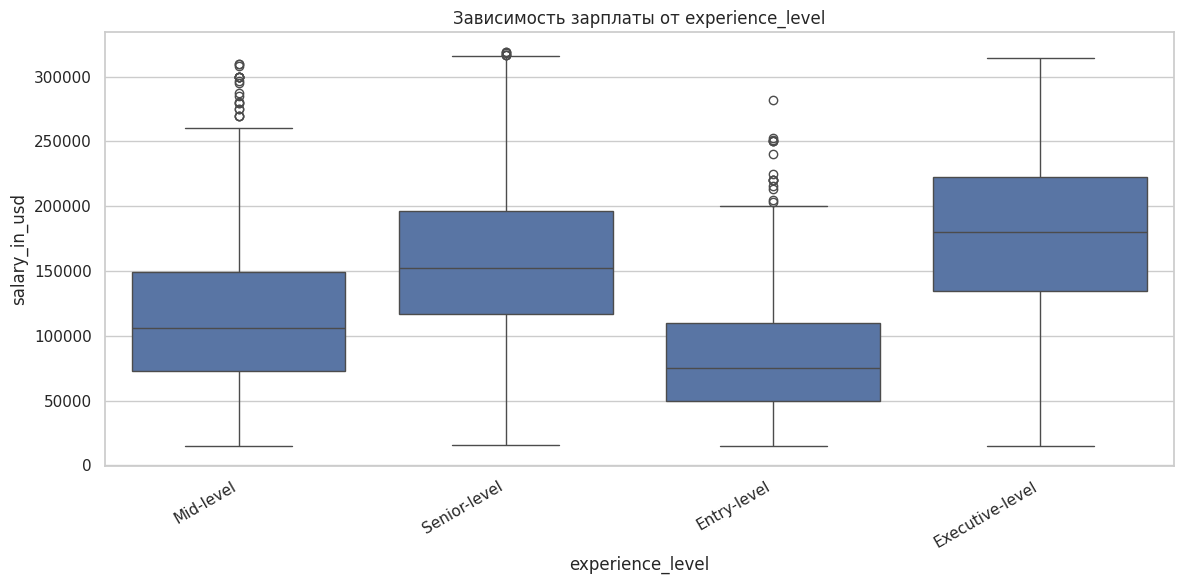


Инсайты по experience_level:
  Медианные зарплаты по категориям (топ-10):
experience_level
Executive-level    180000.0
Senior-level       152000.0
Mid-level          106200.0
Entry-level         75000.0


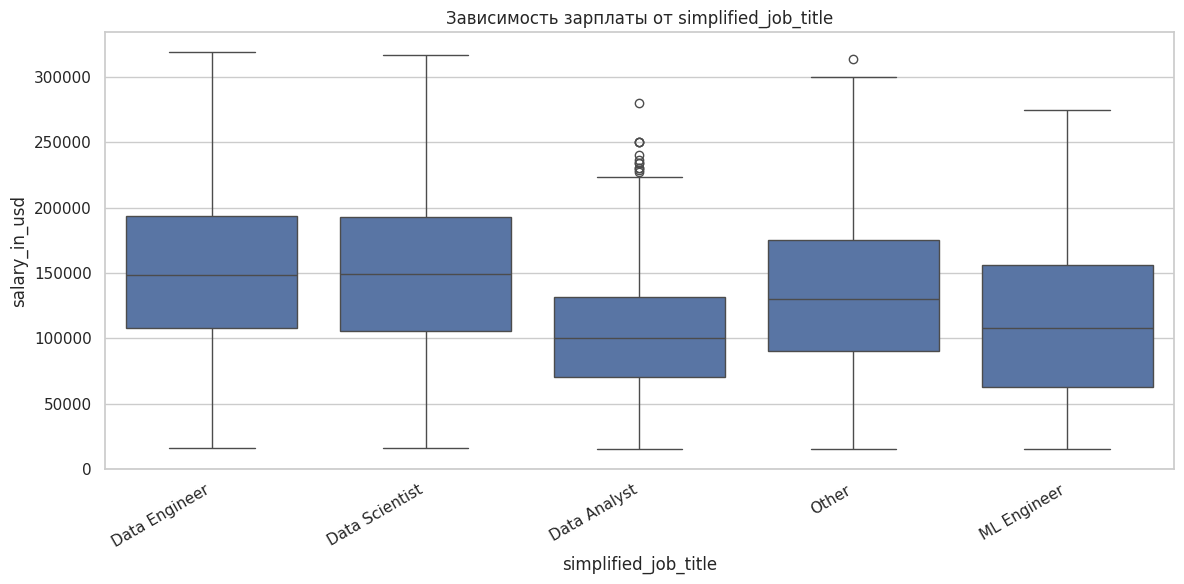


Инсайты по simplified_job_title:
  Медианные зарплаты по категориям (топ-10):
simplified_job_title
Data Scientist    148938.0
Data Engineer     148500.0
Other             130000.0
ML Engineer       108000.0
Data Analyst      100000.0


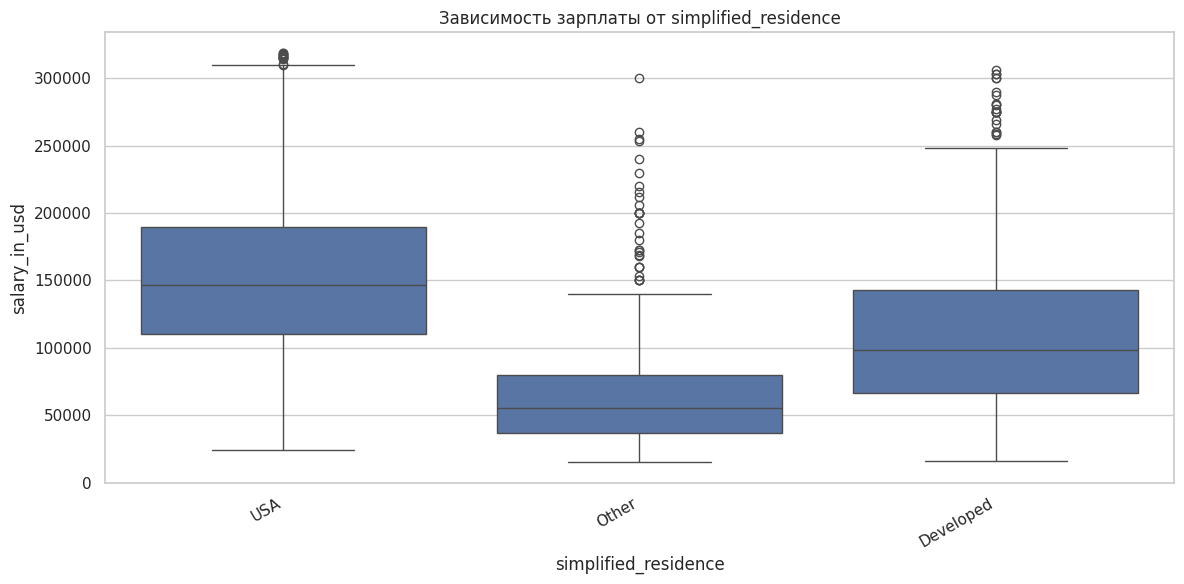


Инсайты по simplified_residence:
  Медианные зарплаты по категориям (топ-10):
simplified_residence
USA          147000.0
Developed     98432.0
Other         55184.0


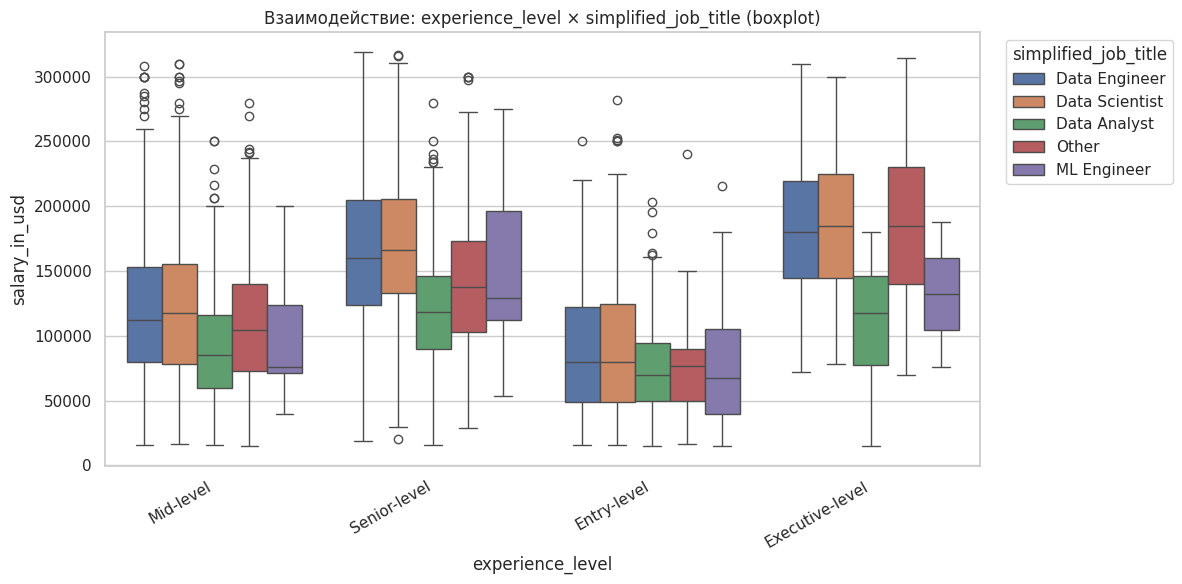


Инсайты по паре признаков experience_level × simplified_job_title:
  Медианные зарплаты по комбинациям категорий (срез):
simplified_job_title  Data Analyst  Data Engineer  Data Scientist  ML Engineer     Other
experience_level                                                                        
Entry-level                70000.0        80000.0         80000.0      67390.5   76833.0
Executive-level           117500.0       180500.0        185000.0     132154.5  184560.0
Mid-level                  85000.0       112000.0        117500.0      75848.5  104584.0
Senior-level              118600.0       160000.0        166500.0     129562.0  138000.0


In [ ]:
# 12) Взаимодействия топ-признаков: одиночные и парные графики + текстовые инсайты

# Проверки наличия объектов
for vname in ("cb_model", "df_fe"):
    if vname not in globals():
        raise RuntimeError(f"{vname} не найден. Убедись, что выполнены предыдущие ячейки.")

# Вытащим топ-фичи по важности
imp_vals = cb_model.get_feature_importance()
imp_names = cb_model.feature_names_
imp_df = pd.DataFrame({"Feature": imp_names, "Importance": imp_vals}).sort_values("Importance", ascending=False)

top_features = [f for f in imp_df["Feature"].tolist() if f in df_fe.columns][:3]
if not top_features:
    raise RuntimeError("Не удалось сопоставить важные признаки с колонками df_fe.")

print("Топ-признаки для анализа взаимодействий:", top_features)

# Универсальные помощники
def _is_low_card_cat(series, thr=15):
    return (series.dtype == "object") or (series.nunique(dropna=True) <= thr)

def _safe_numeric(s):
    return pd.to_numeric(s, errors="coerce")

# 12.1 Одиночные зависимости salary_in_usd от каждого топ-признака
for feat in top_features:
    if feat not in df_fe.columns:
        print(f"[WARN] Признак {feat} отсутствует в df_fe, пропускаем.")
        continue

    plt.figure(figsize=(12, 6))
    s = df_fe[feat]
    if _is_low_card_cat(s):
        # категориальный или низкая кардинальность — boxplot
        sns.boxplot(x=s.astype(str), y=df_fe["salary_in_usd"])
        plt.title(f"Зависимость зарплаты от {feat}")
        plt.xlabel(feat); plt.ylabel("salary_in_usd")
        plt.xticks(rotation=30, ha="right")
    else:
        # числовой — scatter
        sns.scatterplot(x=_safe_numeric(s), y=df_fe["salary_in_usd"], alpha=0.5)
        plt.title(f"Зависимость зарплаты от {feat}")
        plt.xlabel(feat); plt.ylabel("salary_in_usd")

    save_and_show(FIG_DIR / f"interaction_{feat}.png")

    # Текстовые инсайты по фиче
    print(f"\nИнсайты по {feat}:")
    if _is_low_card_cat(s):
        g = df_fe.groupby(s.astype(str))["salary_in_usd"].median().sort_values(ascending=False)
        print("  Медианные зарплаты по категориям (топ-10):")
        print(g.head(10).round(2).to_string())
    else:
        corr = pd.Series(_safe_numeric(s)).corr(df_fe["salary_in_usd"])
        print(f"  Корреляция с целевой (Пирсон): {corr:.4f}")

# 12.2 Парное взаимодействие для первых двух топ-признаков
if len(top_features) >= 2:
    a, b = top_features[0], top_features[1]
    if a in df_fe.columns and b in df_fe.columns:
        plt.figure(figsize=(12, 6))
        a_is_cat = _is_low_card_cat(df_fe[a])
        b_is_cat = _is_low_card_cat(df_fe[b])

        if a_is_cat and b_is_cat:
            sns.boxplot(x=df_fe[a].astype(str), y=df_fe["salary_in_usd"], hue=df_fe[b].astype(str))
            plt.legend(title=b, bbox_to_anchor=(1.02, 1), loc="upper left")
            plt.title(f"Взаимодействие: {a} × {b} (boxplot)")
            plt.xlabel(a); plt.ylabel("salary_in_usd")
            plt.xticks(rotation=30, ha="right")
        else:
            # смешанный/числовой случай — scatter с hue по категор. признаку (если есть)
            if a_is_cat and not b_is_cat:
                sns.scatterplot(x=_safe_numeric(df_fe[b]), y=df_fe["salary_in_usd"], hue=df_fe[a].astype(str), alpha=0.6)
                plt.xlabel(b)
            elif b_is_cat and not a_is_cat:
                sns.scatterplot(x=_safe_numeric(df_fe[a]), y=df_fe["salary_in_usd"], hue=df_fe[b].astype(str), alpha=0.6)
                plt.xlabel(a)
            else:
                # оба числовые
                sns.scatterplot(x=_safe_numeric(df_fe[a]), y=df_fe["salary_in_usd"], hue=pd.qcut(_safe_numeric(df_fe[b]), q=4, duplicates="drop"), alpha=0.6)
                plt.xlabel(a)
            plt.ylabel("salary_in_usd")
            plt.title(f"Взаимодействие: {a} × {b} (scatter)")

        save_and_show(FIG_DIR / f"interaction_pair_{a}_{b}.png")

        # Текстовые инсайты по паре
        print(f"\nИнсайты по паре признаков {a} × {b}:")
        if a_is_cat and b_is_cat:
            tbl = df_fe.pivot_table(index=a, columns=b, values="salary_in_usd", aggfunc="median")
            print("  Медианные зарплаты по комбинациям категорий (срез):")
            print(tbl.round(1).iloc[:5, :5].to_string())  # короткий срез для читаемости
        else:
            # условные медианы по квантилям числового признака
            num = b if not b_is_cat else a if not a_is_cat else None
            cat = a if a_is_cat else b if b_is_cat else None
            if num is not None and cat is not None:
                qbins = pd.qcut(_safe_numeric(df_fe[num]), q=4, duplicates="drop")
                med = df_fe.groupby([cat, qbins])["salary_in_usd"].median().unstack().round(1)
                print(f"  Условные медианы salary_in_usd по {cat} и квартилям {num}:")
                print(med.to_string())
    else:
        print(f"[WARN] Нельзя построить парное взаимодействие: {a} или {b} отсутствует в df_fe.")
else:
    print("Недостаточно признаков для парного взаимодействия (нужно ≥ 2).")


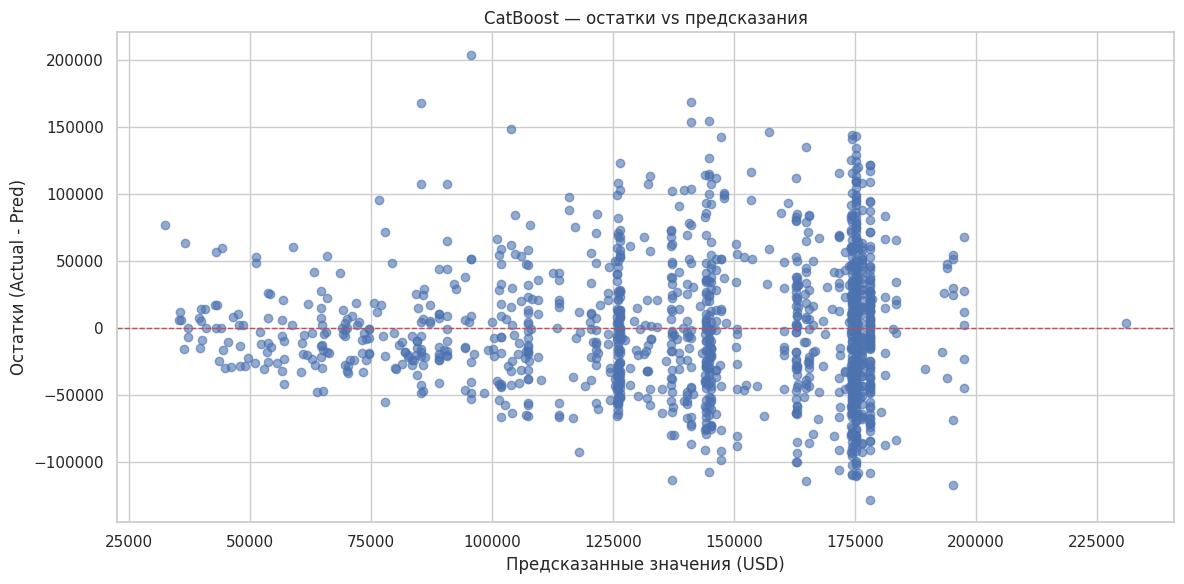

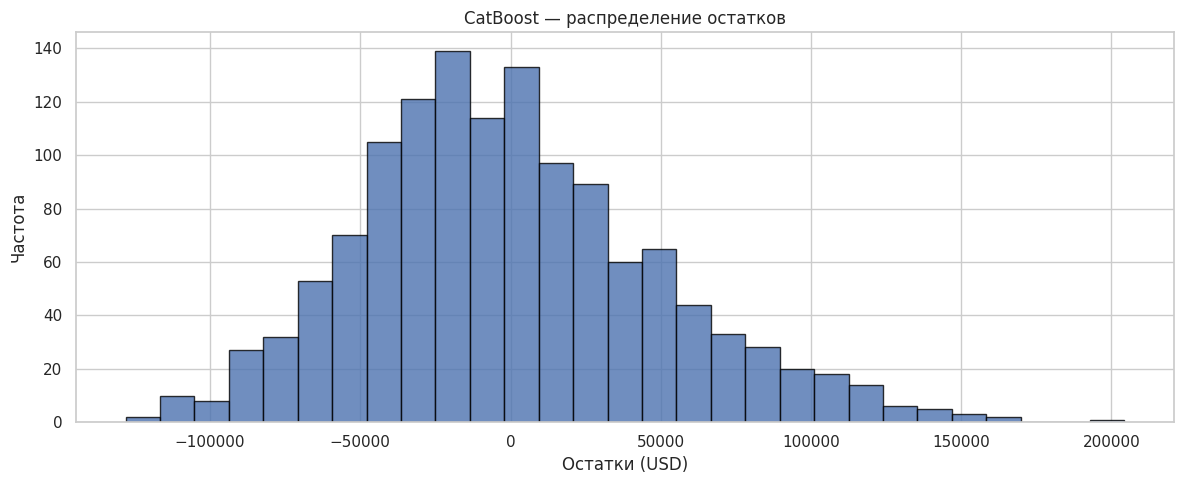


[CatBoost — анализ остатков]
 Среднее остатка (смещение): -589.58 USD
 Ст. отклонение остатков   : 49,873.05 USD
 95-й перцентиль |остатка| : 100,097.85 USD
 Макс |остатка|           : 204,253.19 USD
 Корр(предсказание, остаток): 0.0003  (около 0 — хорошо)

Разброс остатков по квантилям предсказаний (STD по бинам):
pred_bin
(32565.114, 107523.001]     36488.9
(107523.001, 140410.485]    44318.4
(140410.485, 164926.302]    56734.5
(164926.302, 175186.045]    57629.2
(175186.045, 230977.89]     49985.1

Смещение остатков по квантилям предсказаний (MEAN по бинам):
pred_bin
(32565.114, 107523.001]    -1179.6
(107523.001, 140410.485]    -685.5
(140410.485, 164926.302]    1386.7
(164926.302, 175186.045]   -1245.9
(175186.045, 230977.89]    -1169.7


In [ ]:
# 13) Анализ остатков CatBoost — графики (save+show) и текстовая сводка

# проверки наличия артефактов
for vname in ("cb_model", "Xte_cb", "y_test"):
    if vname not in globals():
        raise RuntimeError(f"{vname} не найден. Убедись, что выполнены ячейки 10–12.")

# предсказания и остатки
pred_cb = cb_model.predict(Xte_cb)
residuals = y_test.values - pred_cb

# 13.1 Scatter: предсказание vs остаток
plt.figure(figsize=(12, 6))
plt.scatter(pred_cb, residuals, alpha=0.6)
plt.axhline(0, color="r", ls="--", lw=1)
plt.title("CatBoost — остатки vs предсказания")
plt.xlabel("Предсказанные значения (USD)")
plt.ylabel("Остатки (Actual - Pred)")
save_and_show(FIG_DIR / "cb_residuals_scatter.png")

# 13.2 Гистограмма остатков
plt.figure(figsize=(12, 5))
plt.hist(residuals, bins="auto", edgecolor="black", alpha=0.8, density=False)
plt.title("CatBoost — распределение остатков")
plt.xlabel("Остатки (USD)")
plt.ylabel("Частота")
save_and_show(FIG_DIR / "cb_residuals_hist.png")

# 13.3 Текстовая сводка по остаткам
import numpy as np
mean_res = float(np.mean(residuals))
std_res  = float(np.std(residuals))
abs_max  = float(np.max(np.abs(residuals)))
p95_abs  = float(np.percentile(np.abs(residuals), 95))
corr_pred_res = float(np.corrcoef(pred_cb, residuals)[0, 1])

print("\n[CatBoost — анализ остатков]")
print(f" Среднее остатка (смещение): {mean_res:,.2f} USD")
print(f" Ст. отклонение остатков   : {std_res:,.2f} USD")
print(f" 95-й перцентиль |остатка| : {p95_abs:,.2f} USD")
print(f" Макс |остатка|           : {abs_max:,.2f} USD")
print(f" Корр(предсказание, остаток): {corr_pred_res:.4f}  (около 0 — хорошо)")

# 13.4 Простая проверка гетероскедастичности: группируем по квантилям предсказаний
import pandas as pd
df_res = pd.DataFrame({"pred": pred_cb, "resid": residuals})
df_res["pred_bin"] = pd.qcut(df_res["pred"], q=5, duplicates="drop")
group_std = df_res.groupby("pred_bin")["resid"].std().round(1)
group_mean = df_res.groupby("pred_bin")["resid"].mean().round(1)

print("\nРазброс остатков по квантилям предсказаний (STD по бинам):")
print(group_std.to_string())

print("\nСмещение остатков по квантилям предсказаний (MEAN по бинам):")
print(group_mean.to_string())


Категориальные признаки для анализа ошибок: ['experience_level', 'company_size', 'simplified_job_title']

==== Ошибки по experience_level ====
                  count     mean   median       max
experience_level                                   
Senior-level        820  42253.1  35093.0  168431.2
Executive-level      45  37448.7  29709.9  117181.7
Mid-level           327  34978.4  27620.5  204253.2
Entry-level         107  28991.5  21203.9  148955.6


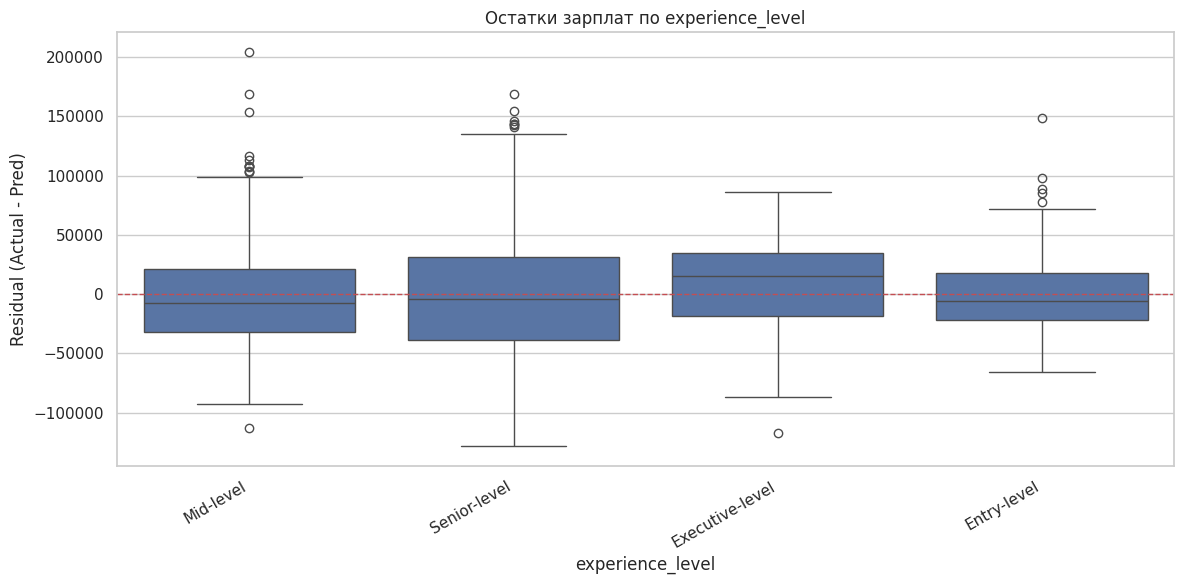


==== Ошибки по company_size ====
              count     mean   median       max
company_size                                   
Medium         1152  40051.5  32967.5  204253.2
Large           110  33783.2  25855.2  116414.0
Small            37  27494.5  21212.1   92559.8


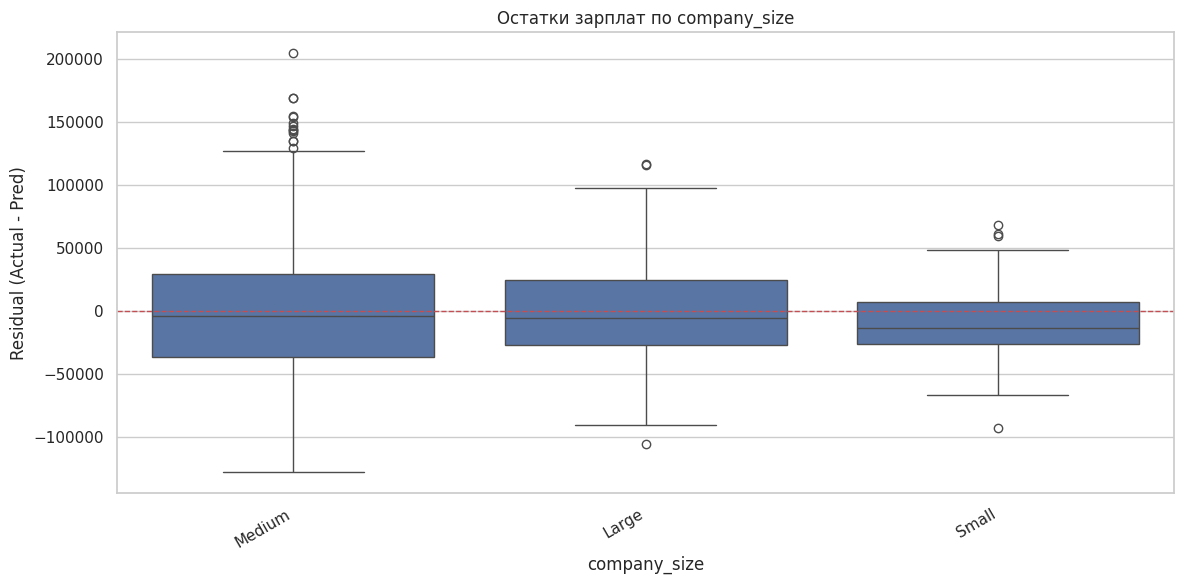


==== Ошибки по simplified_job_title ====
                      count     mean   median       max
simplified_job_title                                   
Data Engineer           574  42258.7  34951.0  204253.2
Data Scientist          363  41626.1  35483.5  168865.9
Other                   123  39324.1  32439.7  154554.4
ML Engineer               7  34284.7  42857.5   60980.0
Data Analyst            232  27711.9  21560.1  123442.0


In [ ]:
# 14) Разбор ошибок по категориям (группы) — графики + сводные таблицы

# проверим наличие df_fe и остатков
for vname in ("df_fe", "pred_cb", "y_test"):
    if vname not in globals():
        raise RuntimeError(f"{vname} не найден. Убедись, что выполнены ячейки 10–13.")

# остатки
residuals = y_test.values - pred_cb
df_errors = df_fe.loc[Xte_cb.index].copy()
df_errors["residual"] = residuals
df_errors["abs_residual"] = df_errors["residual"].abs()

cat_cols_to_check = ["experience_level", "company_size", "simplified_job_title"]
cat_cols_to_check = [c for c in cat_cols_to_check if c in df_errors.columns]

print("Категориальные признаки для анализа ошибок:", cat_cols_to_check)

for col in cat_cols_to_check:
    print(f"\n==== Ошибки по {col} ====")
    stats = df_errors.groupby(col)["abs_residual"].agg(["count", "mean", "median", "max"]).sort_values("mean", ascending=False)
    print(stats.round(1).to_string())

    # boxplot по остаткам
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_errors, x=col, y="residual")
    plt.axhline(0, color="r", ls="--", lw=1)
    plt.title(f"Остатки зарплат по {col}")
    plt.xlabel(col); plt.ylabel("Residual (Actual - Pred)")
    plt.xticks(rotation=30, ha="right")
    save_and_show(FIG_DIR / f"errors_by_{col}.png")



Сравнение моделей (на тесте):
                        MAE      RMSE    R2
Model                                      
Linear Regression  40323.72  50722.43  0.35
Random Forest      39890.45  50989.73  0.34
XGBoost            39429.87  50198.78  0.36
CatBoost           39163.02  49876.54  0.37


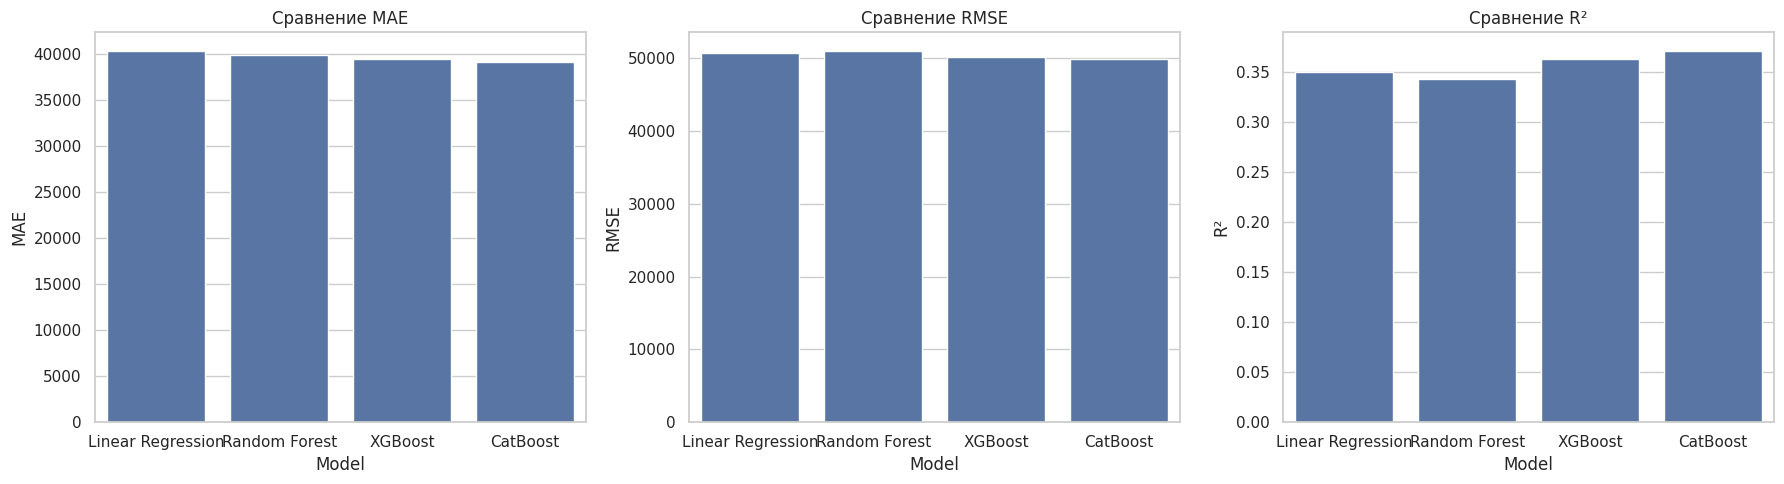

In [ ]:
# 15) Сравнение моделей — таблица метрик и графики (save+show)

# Проверим, что у нас есть метрики всех моделей
metrics_all = []

try:
    metrics_all.append(("Linear Regression", mae_lr, rmse_lr, r2_lr))
except NameError:
    print("[WARN] Метрик для Linear Regression нет — пропускаем.")
try:
    metrics_all.append(("Random Forest", mae_rf, rmse_rf, r2_rf))
except NameError:
    print("[WARN] Метрик для Random Forest нет — пропускаем.")
try:
    metrics_all.append(("XGBoost", mae_xgb, rmse_xgb, r2_xgb))
except NameError:
    print("[WARN] Метрик для XGBoost нет — пропускаем.")
try:
    metrics_all.append(("CatBoost", mae_cb, rmse_cb, r2_cb))
except NameError:
    print("[WARN] Метрик для CatBoost нет — пропускаем.")

if not metrics_all:
    raise RuntimeError("Нет метрик ни для одной модели!")

# Собираем DataFrame
df_metrics = pd.DataFrame(metrics_all, columns=["Model", "MAE", "RMSE", "R2"]).set_index("Model")
print("\nСравнение моделей (на тесте):")
print(df_metrics.round(2).to_string())

# График сравнения (R2 + ошибки)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.barplot(data=df_metrics.reset_index(), x="Model", y="MAE", ax=axes[0])
axes[0].set_title("Сравнение MAE"); axes[0].set_ylabel("MAE")

sns.barplot(data=df_metrics.reset_index(), x="Model", y="RMSE", ax=axes[1])
axes[1].set_title("Сравнение RMSE"); axes[1].set_ylabel("RMSE")

sns.barplot(data=df_metrics.reset_index(), x="Model", y="R2", ax=axes[2])
axes[2].set_title("Сравнение R²"); axes[2].set_ylabel("R²")

plt.tight_layout()
save_and_show(FIG_DIR / "models_comparison.png")


In [ ]:
df = df.drop(['salary', 'salary_currency'], axis=1)

# Обработка выбросов с помощью метода IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_clean = remove_outliers(df, 'salary_in_usd')
print(f"Размер датасета после удаления выбросов: {df_clean.shape[0]} записей (удалено {df.shape[0] - df_clean.shape[0]} выбросов)")

Размер датасета после удаления выбросов: 6492 записей (удалено 107 выбросов)


In [ ]:
df_fe = df_clean.copy()

# 1. Уменьшение размерности job_title
def simplify_job_title(title):
    title = str(title).lower()
    if 'scientist' in title or 'research' in title:
        return 'Data Scientist'
    elif 'engineer' in title or 'architect' in title:
        return 'Data Engineer'
    elif 'analyst' in title or 'bi' in title:
        return 'Data Analyst'
    elif 'ml' in title or 'machine learning' in title or 'ai' in title:
        return 'ML Engineer'
    else:
        return 'Other'

df_fe['simplified_job_title'] = df_fe['job_title'].apply(simplify_job_title)
print("\nРаспределение упрощенных должностей:")
print(df_fe['simplified_job_title'].value_counts())

# 2. Создание бинарных признаков для стран
df_fe['is_usa_residence'] = df_fe['employee_residence'].apply(lambda x: 1 if str(x) == 'United States' else 0)
df_fe['is_usa_company'] = df_fe['company_location'].apply(lambda x: 1 if str(x) == 'United States' else 0)

# 3. Создание признака опыта в годах
year = 2020
df_fe['experience_years'] =  df_fe['work_year'] - year

# 4. Взаимодействие признаков
df_fe['exp_level_size'] = df_fe['experience_level'].astype(str) + '_' + df_fe['company_size'].astype(str)

# 5. Сокращение количества категорий в странах
def simplify_country(country):
    country = str(country)
    if country == 'United States':
        return 'USA'
    elif country in ['Canada', 'United Kingdom', 'Australia', 'Germany', 'France']:
        return 'Developed'
    else:
        return 'Other'

df_fe['simplified_residence'] = df_fe['employee_residence'].apply(simplify_country)
df_fe['simplified_company_loc'] = df_fe['company_location'].apply(simplify_country)


Распределение упрощенных должностей:
simplified_job_title
Data Engineer     2784
Data Scientist    1892
Data Analyst      1161
Other              612
ML Engineer         43
Name: count, dtype: int64


In [ ]:
# Определение категориальных и числовых признаков
categorical_features = [
    'simplified_job_title', 'experience_level', 'employment_type',
    'work_models', 'employee_residence', 'company_location',
    'company_size', 'simplified_residence', 'simplified_company_loc', 'exp_level_size'
]

# Числовые признаки
numerical_features = ['work_year', 'experience_years', 'is_usa_residence', 'is_usa_company']

# Целевая переменная
target = 'salary_in_usd'

# Разделение на признаки и целевую переменную
X = df_fe[categorical_features + numerical_features]
y = df_fe[target]

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ])

In [ ]:

results = {
    'Model': [],
    'MAE': [],
    'RMSE': [],
    'R²': []
}

In [ ]:
# 1. Линейная регрессия
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
lr_pred = lr_pipeline.predict(X_test)

results['Model'].append('Linear Regression')
results['MAE'].append(mean_absolute_error(y_test, lr_pred))
results['RMSE'].append(np.sqrt(mean_squared_error(y_test, lr_pred)))
results['R²'].append(r2_score(y_test, lr_pred))

In [ ]:
# 2. Случайный лес с GridSearchCV
print("\nЗапуск GridSearchCV для Random Forest...")
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Сетка параметров для Random Forest
rf_param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5]
}

rf_grid_search = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

rf_grid_search.fit(X_train, y_train)

# Используем лучшую модель
best_rf = rf_grid_search.best_estimator_
rf_pred = best_rf.predict(X_test)

print(f"Лучшие параметры для Random Forest: {rf_grid_search.best_params_}")
print(f"Лучший R² на кросс-валидации: {rf_grid_search.best_score_:.4f}")

results['Model'].append('Random Forest ( tuned)')
results['MAE'].append(mean_absolute_error(y_test, rf_pred))
results['RMSE'].append(np.sqrt(mean_squared_error(y_test, rf_pred)))
results['R²'].append(r2_score(y_test, rf_pred))




Запуск GridSearchCV для Random Forest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Лучшие параметры для Random Forest: {'regressor__max_depth': 10, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 50}
Лучший R² на кросс-валидации: 0.3489


In [ ]:
# 3. XGBoost
print("\nЗапуск GridSearchCV для XGBoost...")
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(random_state=42, n_jobs=-1))
])


xgb_param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__max_depth': [3, 6],
    'regressor__subsample': [0.8, 1.0]
}

xgb_grid_search = GridSearchCV(
    xgb_pipeline,
    xgb_param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

xgb_grid_search.fit(X_train, y_train)

best_xgb = xgb_grid_search.best_estimator_
xgb_pred = best_xgb.predict(X_test)

print(f"Лучшие параметры для XGBoost: {xgb_grid_search.best_params_}")
print(f"Лучший R² на кросс-валидации: {xgb_grid_search.best_score_:.4f}")

results['Model'].append('XGBoost (tuned)')
results['MAE'].append(mean_absolute_error(y_test, xgb_pred))
results['RMSE'].append(np.sqrt(mean_squared_error(y_test, xgb_pred)))
results['R²'].append(r2_score(y_test, xgb_pred))



Запуск GridSearchCV для XGBoost...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Лучшие параметры для XGBoost: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 100, 'regressor__subsample': 0.8}
Лучший R² на кросс-валидации: 0.3640



=== Упрощенная реализация CatBoost с фиксированными параметрами ===

Используемые признаки для CatBoost:
  - job_title
  - experience_level
  - simplified_residence
  - work_models
  - employee_residence
  - company_location
  - company_size
  - simplified_job_title
  - exp_level_size

Параметры CatBoost:
  iterations: 400
  learning_rate: 0.05
  depth: 7
  l2_leaf_reg: 2
  border_count: 50
  bagging_temperature: 0.5

Обучение CatBoost с оптимизированными параметрами...

Результаты CatBoost с фиксированными параметрами:
MAE: 37923.62
RMSE: 48081.08
R²: 0.4157

=== Анализ важности признаков ===

Топ-10 важных признаков:
                Feature  Importance
0             job_title   20.951545
1      experience_level   19.546448
2  simplified_residence   15.277489
7  simplified_job_title   15.229297
8        exp_level_size    8.161515
5      company_location    6.875904
6          company_size    5.849709
3           work_models    5.762715
4    employee_residence    2.345380


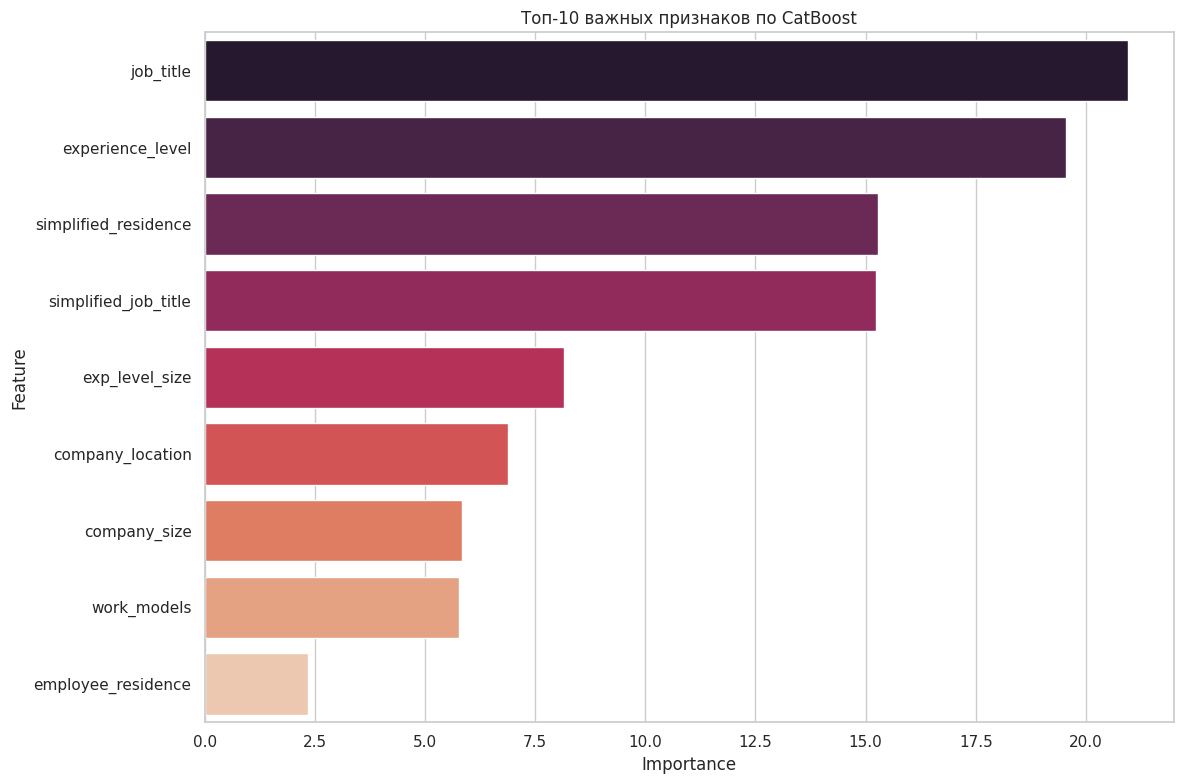


=== Анализ взаимодействия признаков ===


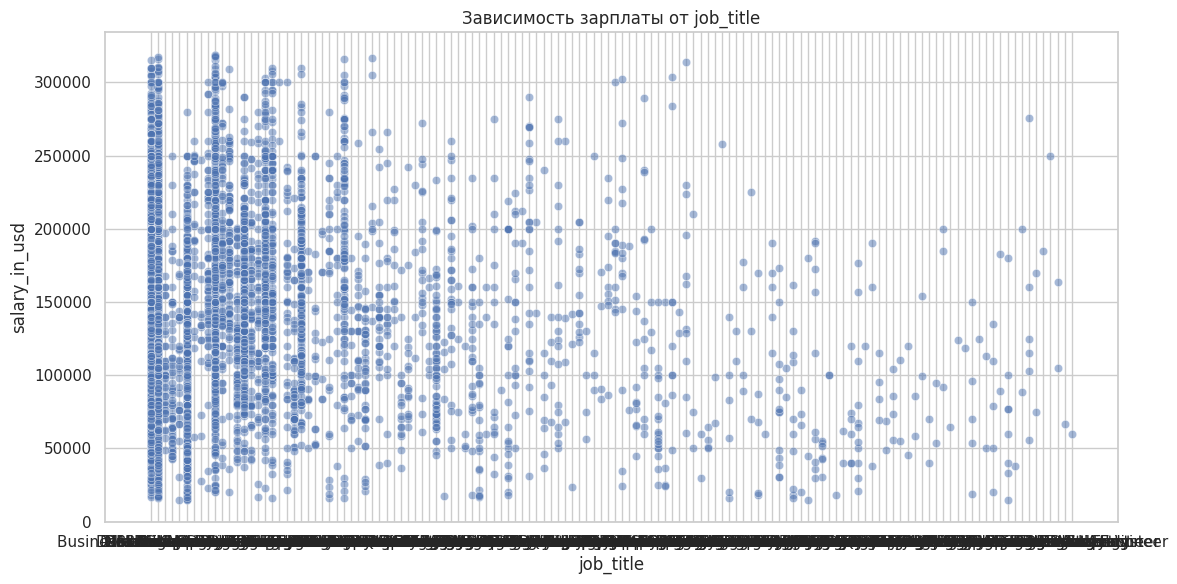

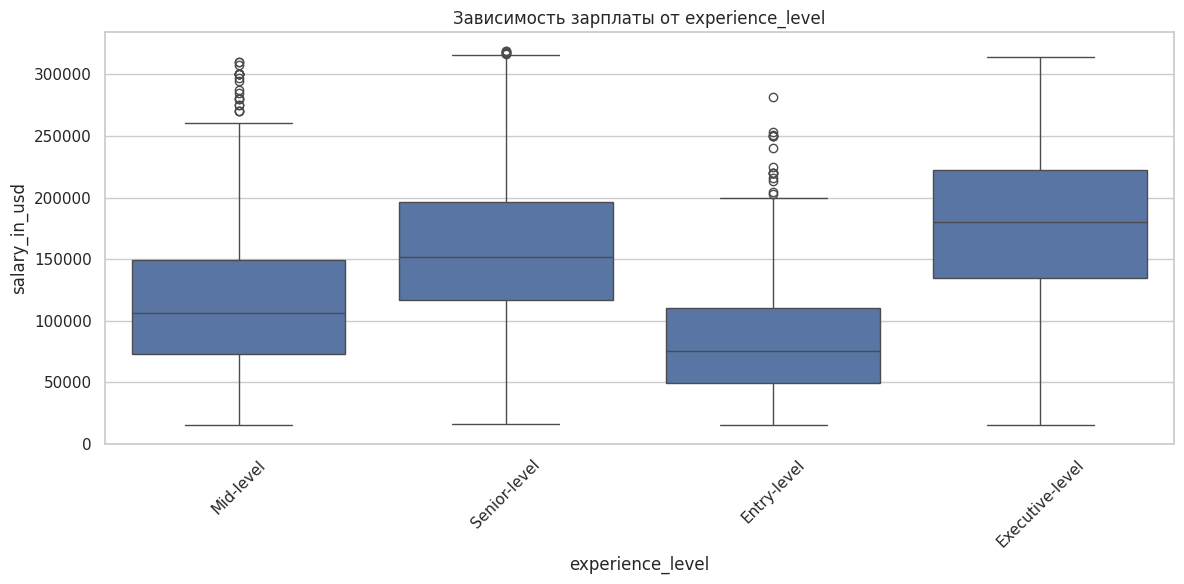

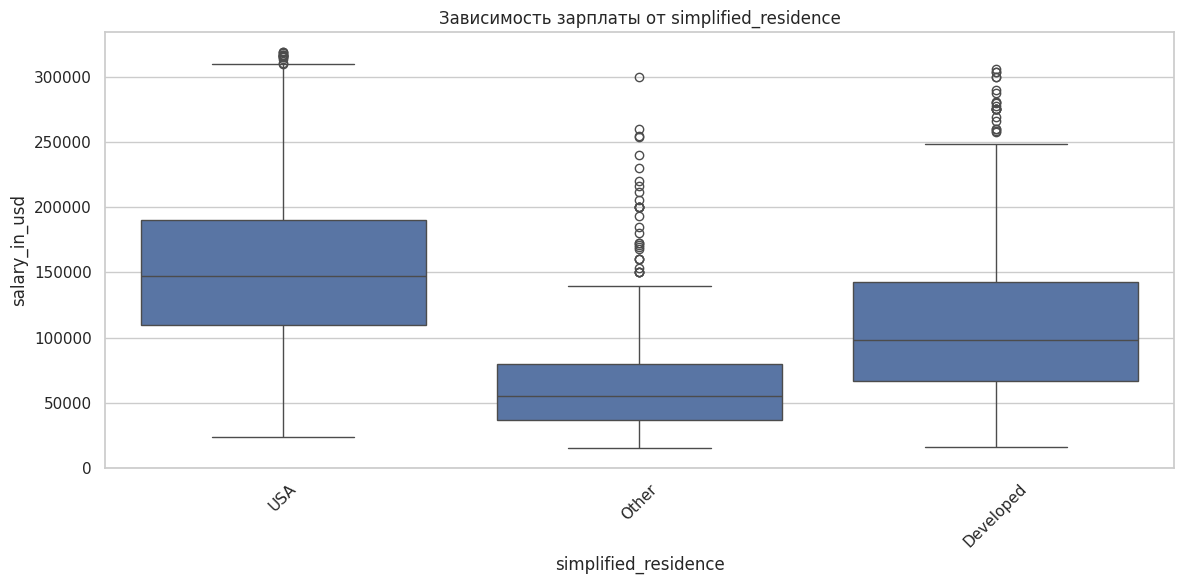

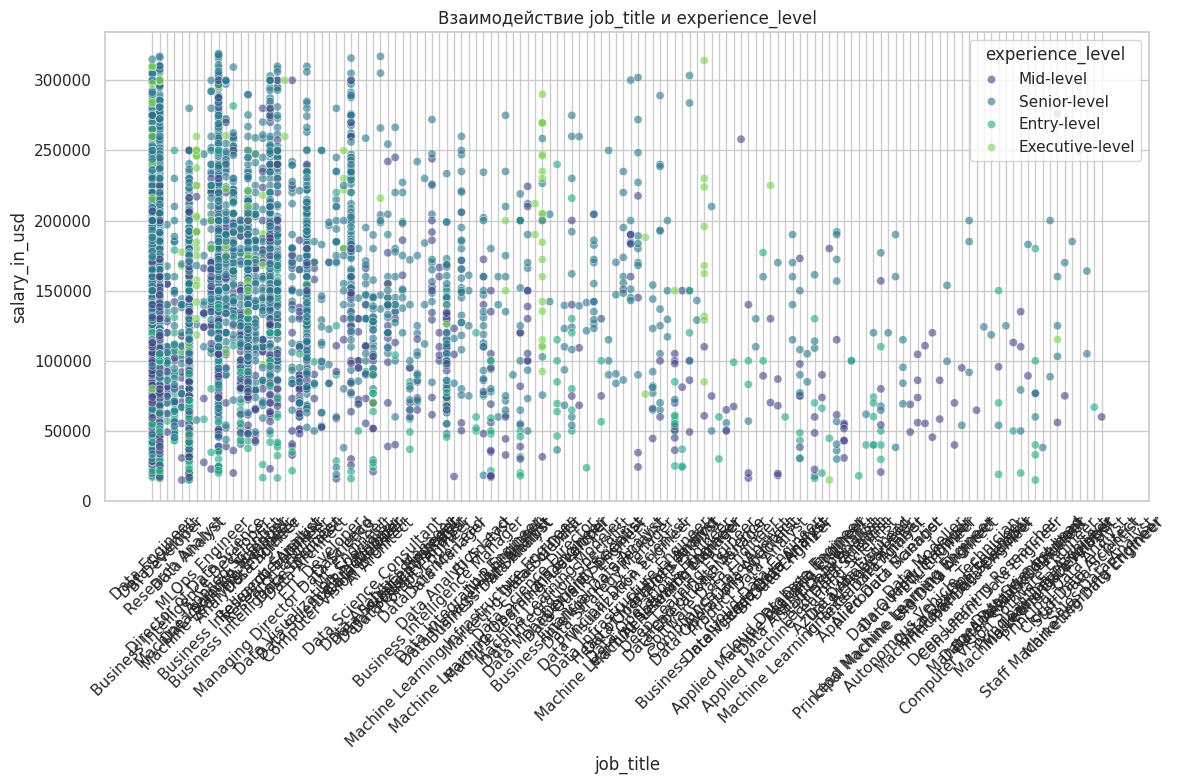


=== Анализ ошибок модели ===


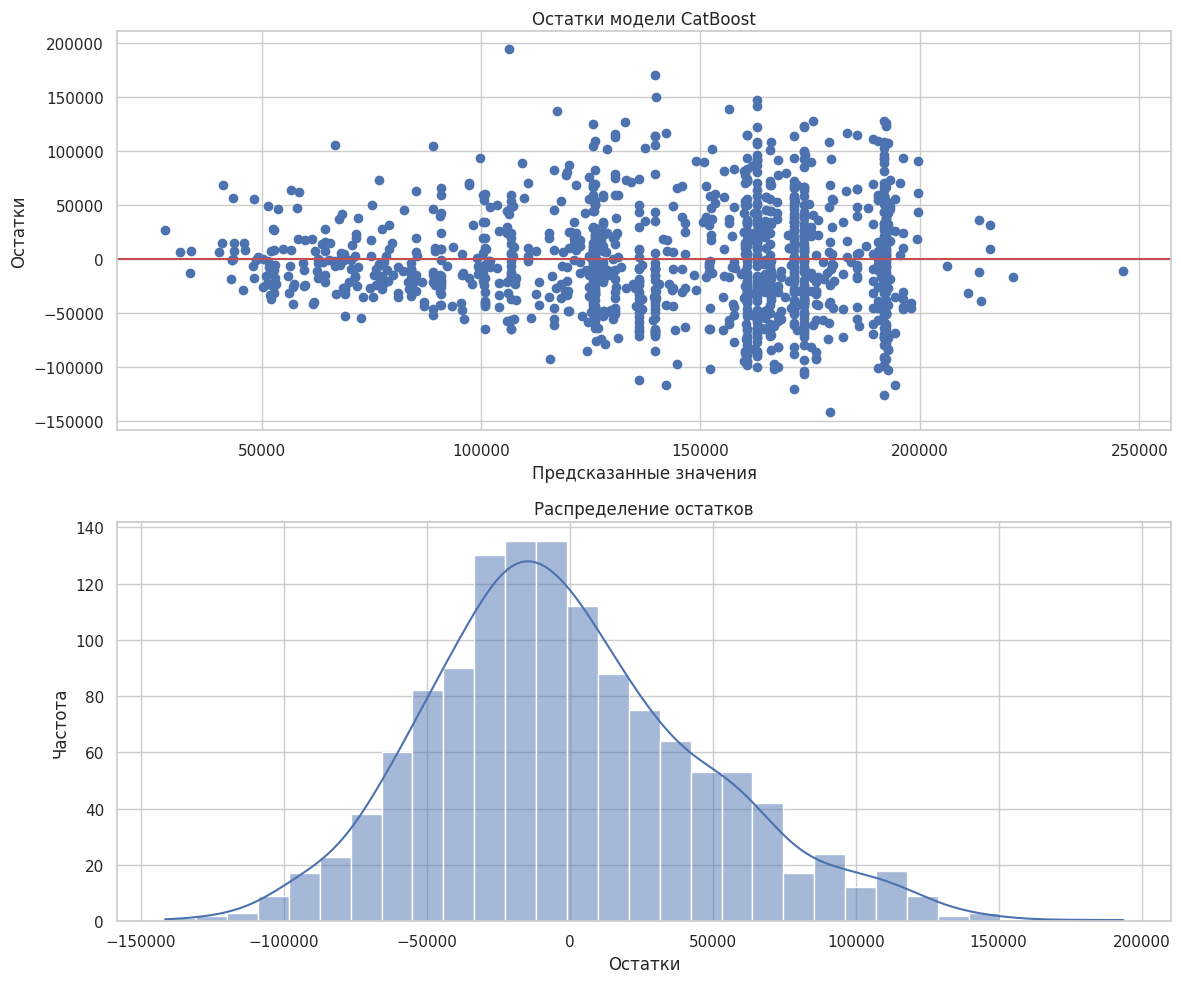


Анализ систематических ошибок:


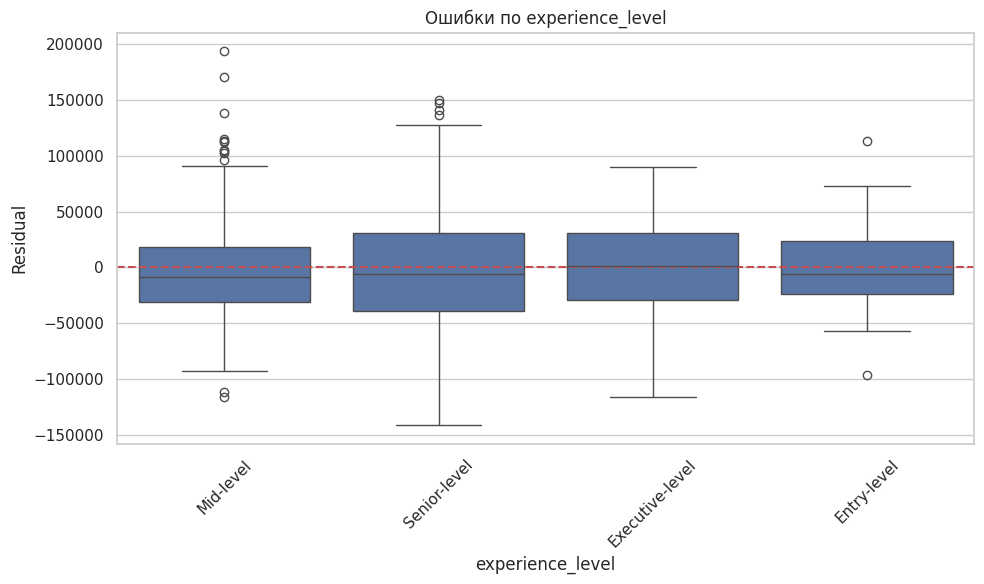


Средняя ошибка по experience_level:
experience_level
Executive-level    3991.396979
Entry-level         790.869265
Senior-level      -1881.536555
Mid-level         -3047.972834
Name: Residual, dtype: float64



Средняя ошибка по company_size:
company_size
Large     1318.578402
Medium   -1854.479868
Small    -7675.514406
Name: Residual, dtype: float64


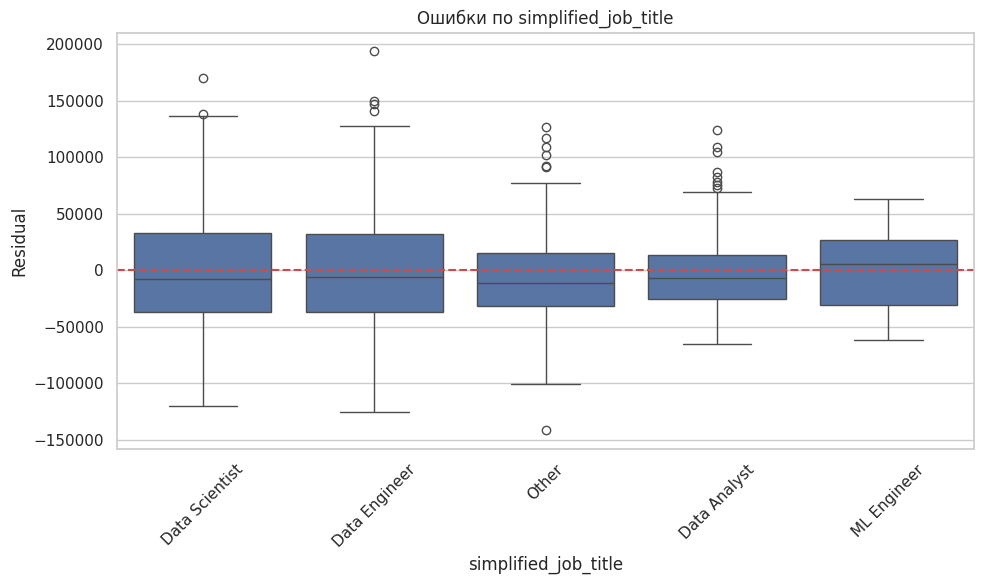


Средняя ошибка по simplified_job_title:
simplified_job_title
ML Engineer        -27.278247
Data Scientist    -799.192349
Data Engineer    -1088.228737
Data Analyst     -3075.566831
Other            -5258.850781
Name: Residual, dtype: float64

=== Примеры самых больших ошибок ===

Топ-10 самых больших ошибок:
1. Фактическая зарплата: $300,000, Предсказанная: $106,403, Ошибка: $193,597
   Должность: Data Engineer, Опыт: Mid-level, Страна: United Kingdom, Размер компании: Medium

2. Фактическая зарплата: $310,000, Предсказанная: $139,607, Ошибка: $170,393
   Должность: Data Scientist, Опыт: Mid-level, Страна: United States, Размер компании: Medium

3. Фактическая зарплата: $289,800, Предсказанная: $139,906, Ошибка: $149,894
   Должность: Data Engineer, Опыт: Senior-level, Страна: United Kingdom, Размер компании: Medium

4. Фактическая зарплата: $310,000, Предсказанная: $162,962, Ошибка: $147,038
   Должность: Data Engineer, Опыт: Senior-level, Страна: United States, Размер компании: Medi

In [ ]:
# === 4. Упрощенная реализация CatBoost с фиксированными параметрами ===

print("\n=== Упрощенная реализация CatBoost с фиксированными параметрами ===")

catboost_features = [
    'job_title', 'experience_level','simplified_residence',
    'work_models', 'employee_residence', 'company_location',
    'company_size', 'simplified_job_title',
    'exp_level_size'
]

# Подготовка данных для CatBoost с выбранными признаками
X_train_cat = df_fe.loc[X_train.index][catboost_features]
X_test_cat = df_fe.loc[X_test.index][catboost_features]

# Определение категориальных признаков для CatBoost
categorical_features_for_catboost = [
    'job_title', 'experience_level', 'simplified_residence',
    'work_models', 'employee_residence', 'company_location',
    'company_size', 'simplified_job_title', 'exp_level_size'
]

print("\nИспользуемые признаки для CatBoost:")
for feature in catboost_features:
    print(f"  - {feature}")

# Фиксированные параметры CatBoost, оптимизированные для данного датасета
catboost_params = {
    'iterations': 400,
    'learning_rate': 0.05,
    'depth': 7,
    'l2_leaf_reg': 2,
    'border_count': 50,
    'bagging_temperature': 0.5,
    'verbose': 0,
    'random_state': 42
}

print("\nПараметры CatBoost:")
for param, value in catboost_params.items():
    if param != 'verbose' and param != 'random_state':
        print(f"  {param}: {value}")

# Обучение CatBoost с фиксированными параметрами
print("\nОбучение CatBoost с оптимизированными параметрами...")
catboost_model = CatBoostRegressor(
    **catboost_params,
    cat_features=categorical_features_for_catboost
)

# Обучение модели
catboost_model.fit(X_train_cat, y_train)

# Получаем предсказания
catboost_pred = catboost_model.predict(X_test_cat)

# Оценка качества
mae = mean_absolute_error(y_test, catboost_pred)
rmse = np.sqrt(mean_squared_error(y_test, catboost_pred))
r2 = r2_score(y_test, catboost_pred)

print(f"\nРезультаты CatBoost с фиксированными параметрами:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Добавляем результаты в общий список
results['Model'].append('CatBoost (optimized)')
results['MAE'].append(mae)
results['RMSE'].append(rmse)
results['R²'].append(r2)

# === 5. Анализ важности признаков для упрощенной модели ===

print("\n=== Анализ важности признаков ===")

# Получаем важность признаков
feature_importance = catboost_model.get_feature_importance()
feature_names = catboost_model.feature_names_

# Создаем DataFrame для визуализации
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Берем топ-10 признаков
top_importance = importance_df.head(10)

# Выводим таблицу важности признаков
print("\nТоп-10 важных признаков:")
print(top_importance)

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_importance, palette='rocket')
plt.title('Топ-10 важных признаков по CatBoost')
plt.tight_layout()
plt.savefig('feature_importance_optimized.png')
plt.show()

# === 6. Анализ взаимодействия признаков ===

print("\n=== Анализ взаимодействия признаков ===")

# Выбираем топ-3 самых важных признака
top_features = importance_df['Feature'].head(3).tolist()

# Для каждого топ-признака строим график зависимости зарплаты
for feature in top_features:
    plt.figure(figsize=(12, 6))

    if df_fe[feature].nunique() < 15:  # Если категориальный признак с небольшим числом уникальных значений
        sns.boxplot(x=feature, y='salary_in_usd', data=df_fe)
        plt.title(f'Зависимость зарплаты от {feature}')
        plt.xticks(rotation=45)
    else:  # Если числовой признак или категориальный с большим числом уникальных значений
        sns.scatterplot(x=feature, y='salary_in_usd', data=df_fe, alpha=0.5)
        plt.title(f'Зависимость зарплаты от {feature}')

    plt.tight_layout()
    plt.savefig(f'feature_interaction_{feature}.png')
    plt.show()

# Для взаимодействия признаков используем парные графики для топ-2 признаков
if len(top_features) >= 2:
    plt.figure(figsize=(12, 8))

    if df_fe[top_features[0]].nunique() < 10 and df_fe[top_features[1]].nunique() < 10:
        # Для категориальных признаков
        sns.boxplot(x=top_features[0], y='salary_in_usd', hue=top_features[1], data=df_fe)
        plt.title(f'Взаимодействие {top_features[0]} и {top_features[1]}')
        plt.legend(title=top_features[1])
    else:
        # Для числовых или смешанных признаков
        sns.scatterplot(x=top_features[0], y='salary_in_usd',
                        hue=top_features[1], data=df_fe, palette='viridis', alpha=0.6)
        plt.title(f'Взаимодействие {top_features[0]} и {top_features[1]}')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'feature_interaction_{top_features[0]}_{top_features[1]}.png')
    plt.show()

# === 7. Анализ ошибок модели ===

print("\n=== Анализ ошибок модели ===")

# Вычисляем остатки
residuals = y_test.values - catboost_pred

# Визуализация остатков
plt.figure(figsize=(12, 10))

# График остатков
plt.subplot(2, 1, 1)
plt.scatter(catboost_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Остатки модели CatBoost')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')

# Распределение остатков
plt.subplot(2, 1, 2)
sns.histplot(residuals, kde=True)
plt.title('Распределение остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')

plt.tight_layout()
plt.savefig('catboost_residual_analysis.png')
plt.show()

# Анализ систематических ошибок
print("\nАнализ систематических ошибок:")
error_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': catboost_pred,
    'Residual': residuals
})

# Добавляем признаки из тестовой выборки для анализа
error_analysis = pd.concat([error_df, X_test.reset_index(drop=True)], axis=1)

# Анализ ошибок по ключевым категориям
for feature in ['experience_level', 'company_size', 'simplified_job_title']:
    if feature in error_analysis.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=feature, y='Residual', data=error_analysis)
        plt.title(f'Ошибки по {feature}')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f'error_analysis_{feature}.png')
        plt.show()

        # Выводим среднюю ошибку по категории
        print(f"\nСредняя ошибка по {feature}:")
        print(error_analysis.groupby(feature)['Residual'].mean().sort_values(ascending=False))

# === 8. Примеры самых больших ошибок ===

print("\n=== Примеры самых больших ошибок ===")

# Находим 5 самых больших положительных и отрицательных ошибок
top_errors = error_analysis.reindex(error_analysis['Residual'].abs().sort_values(ascending=False).index).head(10)

print("\nТоп-10 самых больших ошибок:")
for i, (_, row) in enumerate(top_errors.iterrows(), 1):
    print(f"{i}. Фактическая зарплата: ${row['Actual']:,.0f}, Предсказанная: ${row['Predicted']:,.0f}, "
          f"Ошибка: ${row['Residual']:,.0f}")
    print(f"   Должность: {row['simplified_job_title']}, Опыт: {row['experience_level']}, "
          f"Страна: {row['employee_residence']}, Размер компании: {row['company_size']}\n")

# Сохраняем модель для дальнейшего использования
import joblib
joblib.dump(catboost_model, 'catboost_salary_model.pkl')
print("\nМодель сохранена в файл 'catboost_salary_model.pkl'")

# Выбираем эту версию CatBoost как финальную для сравнения с другими моделями
best_catboost_model = catboost_model


Результаты сравнения моделей:
                    Model           MAE          RMSE        R²
0       Linear Regression  40323.718341  50722.431309  0.349705
1  Random Forest ( tuned)  39981.802947  51029.392448  0.341810
2         XGBoost (tuned)  39440.296875  50177.494876  0.363603
3    CatBoost (optimized)  37923.623216  48081.078116  0.415669


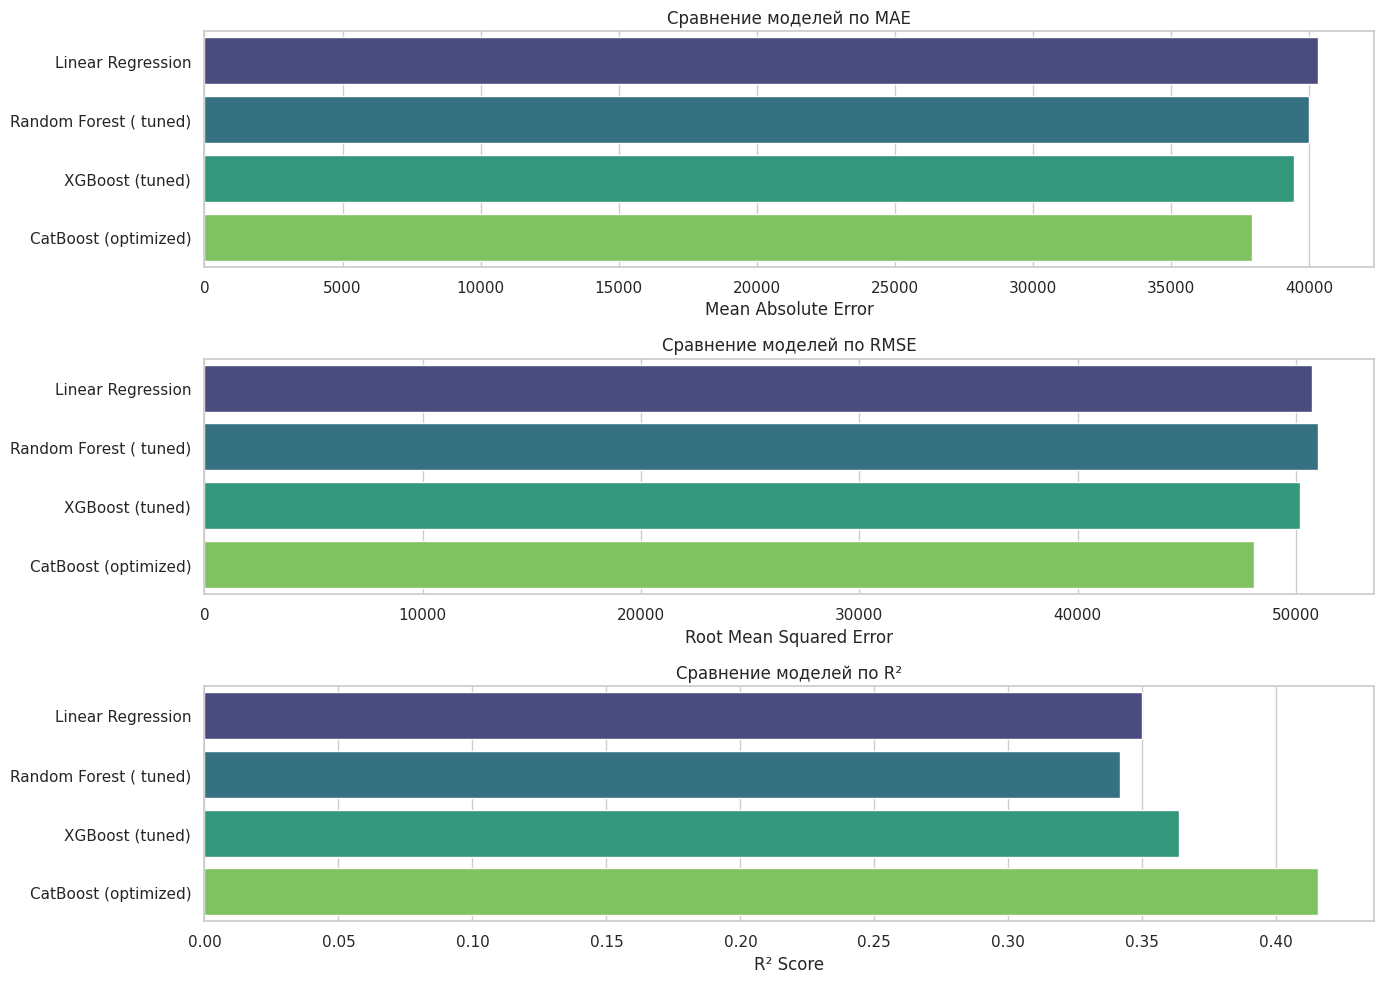

In [ ]:
results_df = pd.DataFrame(results)
print("\nРезультаты сравнения моделей:")
print(results_df)

# Визуализация результатов
plt.figure(figsize=(14, 10))

# MAE
plt.subplot(3, 1, 1)
sns.barplot(x='MAE', y='Model', data=results_df, palette='viridis')
plt.title('Сравнение моделей по MAE')
plt.xlabel('Mean Absolute Error')
plt.ylabel('')

# RMSE
plt.subplot(3, 1, 2)
sns.barplot(x='RMSE', y='Model', data=results_df, palette='viridis')
plt.title('Сравнение моделей по RMSE')
plt.xlabel('Root Mean Squared Error')
plt.ylabel('')

# R²
plt.subplot(3, 1, 3)
sns.barplot(x='R²', y='Model', data=results_df, palette='viridis')
plt.title('Сравнение моделей по R²')
plt.xlabel('R² Score')
plt.ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
best_model_idx = results_df['R²'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']

# Для CatBoost
feature_importance = catboost_model.get_feature_importance()
feature_names = catboost_model.feature_names_

# Создаем DataFrame для визуализации
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Берем топ-15 признаков
top_importance = importance_df.head(15)

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_importance, palette='rocket')
plt.title(f'Важные признаки по {best_model_name}')
plt.tight_layout()
plt.show()



In [ ]:
best_model_idx = results_df['R²'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']

pred = catboost_pred
residuals = y_test.values - catboost_pred


# Визуализация остатков
plt.figure(figsize=(12, 10))

# График остатков
plt.subplot(2, 1, 1)
plt.scatter(pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title(f'Остатки лучшей модели ({best_model_name})')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')

# Распределение остатков
plt.subplot(2, 1, 2)
sns.histplot(residuals, kde=True)
plt.title('Распределение остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()


=== Расширенное сравнение версий CatBoost ===

1. CatBoost на исходном датасете (без feature engineering)...
Пользуемся встроенными возможностями CatBoost для обработки категориальных признаков

Категориальные признаки для исходной версии CatBoost:
  - job_title
  - experience_level
  - employment_type
  - work_models
  - employee_residence
  - company_location
  - company_size

Обучение CatBoost на исходном датасете...

Качество модели CatBoost на исходном датасете:
  MAE: 38111.16
  RMSE: 48020.93
  R²: 0.4171



2. CatBoost с текстовыми эмбеддингами для job_title...
Используем TF-IDF и Word2Vec для создания семантических эмбеддингов

Создание TF-IDF эмбеддингов...
Создание Word2Vec эмбеддингов...
Создано 70 текстовых эмбеддингов

Категориальные признаки для версии с эмбеддингами:
  - job_title
  - experience_level
  - employment_type
  - work_models
  - employee_residence
  - company_location
  - company_size
  - simplified_job_title
  - simplified_residence
  - simplified_company_loc
  - exp_level_size

Проверка типов данных категориальных признаков:
  job_title: object
  experience_level: object
  employment_type: object
  work_models: object
  employee_residence: object
  company_location: object
  company_size: object
  simplified_job_title: object
  simplified_residence: object
  simplified_company_loc: object
  exp_level_size: object

Обучение CatBoost с текстовыми эмбеддингами...

Качество модели CatBoost с текстовыми эмбеддингами:
  MAE: 37847.56
  RMSE: 47978.89
  R²: 0.4182

3. Срав

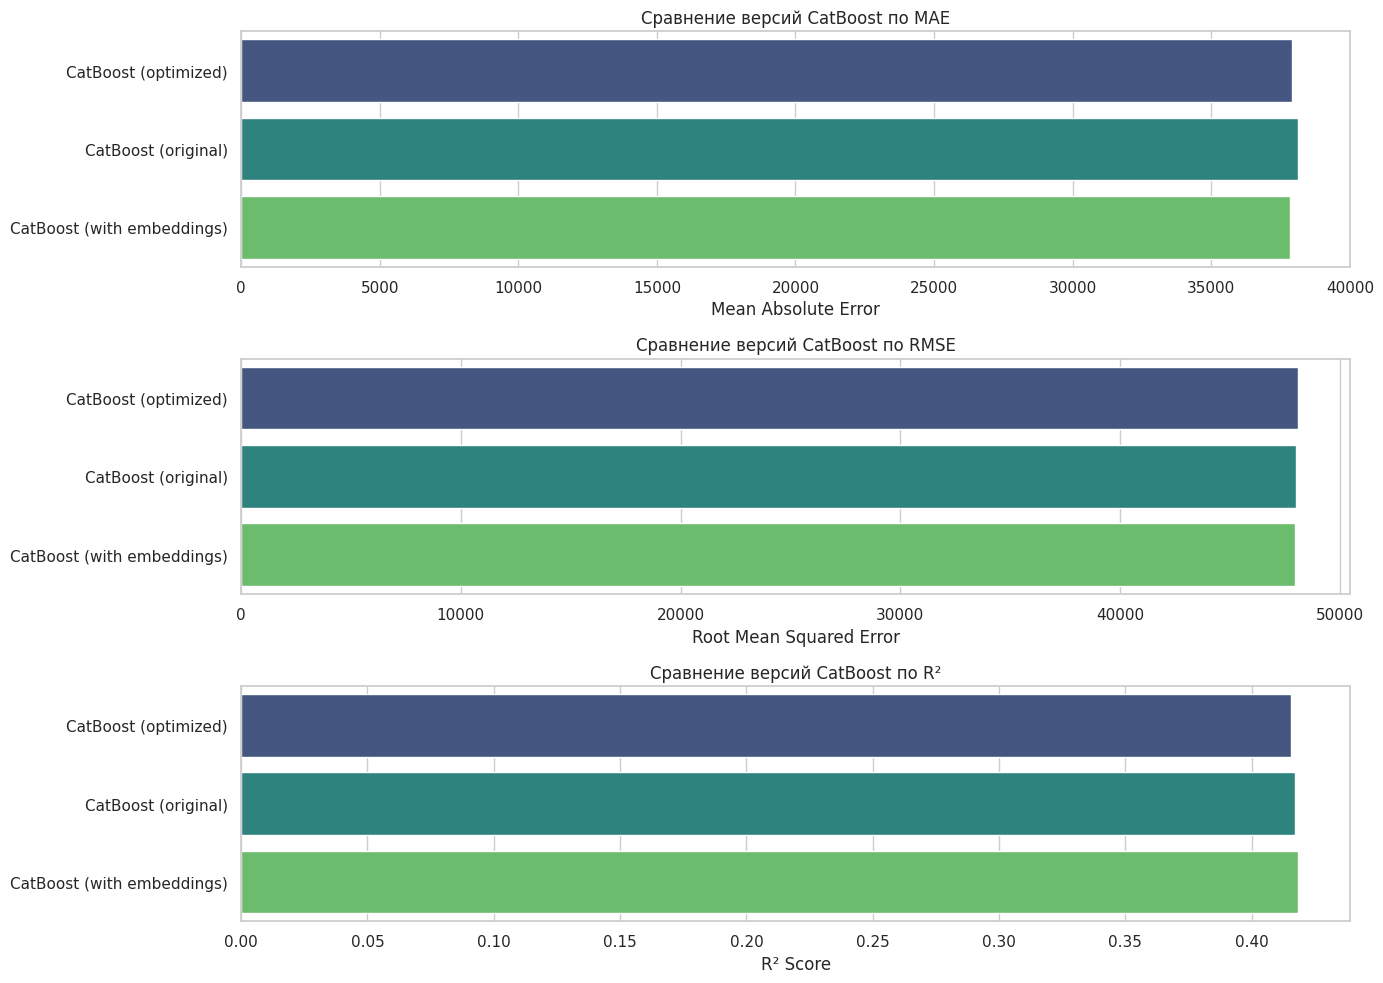


Анализ улучшения по сравнению с базовой версией (CatBoost original):
Базовый R²: 0.4171
Улучшение от feature engineering: -0.0015 (-0.35%)
Улучшение от текстовых эмбеддингов: 0.0010 (0.24%)

5. Выбор лучшей версии CatBoost...

Лучшая версия: CatBoost (with embeddings) с R² = 0.4182
Используем версию с текстовыми эмбеддингами

Анализ завершен. Выбрана лучшая версия CatBoost для дальнейшего использования.


In [ ]:
import re

# === 4. Расширенное сравнение версий CatBoost ===

print("\n=== Расширенное сравнение версий CatBoost ===")

# === 4.1 CatBoost на исходном датасете ===
print("\n1. CatBoost на исходном датасете (без feature engineering)...")
print("Пользуемся встроенными возможностями CatBoost для обработки категориальных признаков")

# Используем исходный датасет без feature engineering
df_original = df_clean.copy()

# Разделение на обучающую и тестовую выборки
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    df_original.drop('salary_in_usd', axis=1),
    df_original['salary_in_usd'],
    test_size=0.2,
    random_state=42
)

# Определение категориальных признаков для CatBoost
categorical_features_orig = [
    'job_title', 'experience_level', 'employment_type',
    'work_models', 'employee_residence', 'company_location',
    'company_size'
]

print("\nКатегориальные признаки для исходной версии CatBoost:")
for feature in categorical_features_orig:
    print(f"  - {feature}")

# Обучение CatBoost на исходном датасете с оптимальными параметрами
print("\nОбучение CatBoost на исходном датасете...")

# Используем те же оптимальные параметры, что и в предыдущей версии
best_model_orig = CatBoostRegressor(
    iterations=400,
    learning_rate=0.05,
    depth=7,
    l2_leaf_reg=2,
    border_count=50,
    bagging_temperature=0.5,
    cat_features=categorical_features_orig,
    verbose=0,
    random_state=42
)

# Обучаем модель
best_model_orig.fit(
    X_train_orig,
    y_train_orig,
    eval_set=(X_test_orig, y_test_orig),
    use_best_model=True,
    early_stopping_rounds=50
)

# Получаем предсказания
catboost_pred_orig = best_model_orig.predict(X_test_orig)

# Оцениваем качество модели
mae_orig = mean_absolute_error(y_test_orig, catboost_pred_orig)
rmse_orig = np.sqrt(mean_squared_error(y_test_orig, catboost_pred_orig))
r2_orig = r2_score(y_test_orig, catboost_pred_orig)

print(f"\nКачество модели CatBoost на исходном датасете:")
print(f"  MAE: {mae_orig:.2f}")
print(f"  RMSE: {rmse_orig:.2f}")
print(f"  R²: {r2_orig:.4f}")

# Добавляем результаты в общий список
results['Model'].append('CatBoost (original)')
results['MAE'].append(mae_orig)
results['RMSE'].append(rmse_orig)
results['R²'].append(r2_orig)

# Анализ важности признаков для исходной версии
feature_importance_orig = best_model_orig.get_feature_importance()
feature_names_orig = best_model_orig.feature_names_

# Создаем DataFrame для визуализации
importance_df_orig = pd.DataFrame({
    'Feature': feature_names_orig,
    'Importance': feature_importance_orig
}).sort_values('Importance', ascending=False)

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_orig.head(15), palette='magma')
plt.title('Важность признаков в модели CatBoost (исходный датасет)')
plt.tight_layout()
plt.savefig('feature_importance_original.png')
plt.show()

# === 4.2 CatBoost с текстовыми эмбеддингами для job_title ===
print("\n2. CatBoost с текстовыми эмбеддингами для job_title...")
print("Используем TF-IDF и Word2Vec для создания семантических эмбеддингов")

# ИСПРАВЛЕНО: Используем df_fe (с уже выполненными преобразованиями), а не df_clean
df_with_embeddings = df_fe.copy()

# Создаем копию оригинального job_title для обработки
df_with_embeddings['job_title_original'] = df_clean['job_title'].copy()

# Функция для очистки текста
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)  # Удаляем пунктуацию
    return text

# Очищаем job_title
df_with_embeddings['job_title_clean'] = df_with_embeddings['job_title_original'].apply(preprocess_text)

# 1. TF-IDF эмбеддинги
print("\nСоздание TF-IDF эмбеддингов...")
tfidf = TfidfVectorizer(max_features=50)
tfidf_matrix = tfidf.fit_transform(df_with_embeddings['job_title_clean'])
tfidf_features = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=[f'tfidf_{i}' for i in range(tfidf_matrix.shape[1])],
    index=df_with_embeddings.index
)

# 2. Word2Vec эмбеддинги
print("Создание Word2Vec эмбеддингов...")
# Подготовка предложений для Word2Vec
sentences = [title.split() for title in df_with_embeddings['job_title_clean']]

# Обучаем модель Word2Vec
word2vec_model = Word2Vec(sentences, vector_size=20, window=5, min_count=1, workers=4)

# Функция для получения эмбеддингов
def get_word2vec_embedding(title):
    words = title.split()
    vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

# Получаем эмбеддинги для всех job_title
word2vec_embeddings = np.array(df_with_embeddings['job_title_clean'].apply(get_word2vec_embedding).tolist())
word2vec_features = pd.DataFrame(
    word2vec_embeddings,
    columns=[f'w2v_{i}' for i in range(word2vec_embeddings.shape[1])],
    index=df_with_embeddings.index
)

# Объединяем эмбеддинги
all_embeddings = pd.concat([tfidf_features, word2vec_features], axis=1)
print(f"Создано {all_embeddings.shape[1]} текстовых эмбеддингов")

# Добавляем эмбеддинги в датасет
df_with_embeddings = pd.concat([df_with_embeddings, all_embeddings], axis=1)

# ИСПРАВЛЕНО: Удаляем ВСЕ оригинальные текстовые признаки job_title
df_with_embeddings = df_with_embeddings.drop(['job_title_original', 'job_title_clean'], axis=1)

# Подготовка данных для CatBoost с эмбеддингами
X_with_embeddings = df_with_embeddings.drop('salary_in_usd', axis=1)
y_with_embeddings = df_with_embeddings['salary_in_usd']

# Разделение на обучающую и тестовую выборки
X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(
    X_with_embeddings, y_with_embeddings, test_size=0.2, random_state=42
)

# Определение категориальных признаков для CatBoost (без job_title)
categorical_features_emb = [
    "job_title", 'experience_level', 'employment_type',
    'work_models', 'employee_residence', 'company_location',
    'company_size', 'simplified_job_title', 'simplified_residence',
    'simplified_company_loc', 'exp_level_size'
]

print("\nКатегориальные признаки для версии с эмбеддингами:")
for feature in categorical_features_emb:
    print(f"  - {feature}")

# Проверяем, что все категориальные признаки присутствуют в данных
missing_features = [feat for feat in categorical_features_emb if feat not in X_train_emb.columns]
if missing_features:
    print(f"\nВНИМАНИЕ: Отсутствующие признаки: {missing_features}")
    # Удаляем отсутствующие признаки из списка категориальных
    categorical_features_emb = [feat for feat in categorical_features_emb if feat in X_train_emb.columns]
    print("Обновленный список категориальных признаков:")
    for feature in categorical_features_emb:
        print(f"  - {feature}")

# ИСПРАВЛЕНО: Проверяем типы данных для категориальных признаков
print("\nПроверка типов данных категориальных признаков:")
for feature in categorical_features_emb:
    if feature in X_train_emb.columns:
        dtype = X_train_emb[feature].dtype
        print(f"  {feature}: {dtype}")
        # Если признак числовой, но должен быть категориальным, преобразуем его в строку
        if np.issubdtype(dtype, np.number):
            print(f"    Предупреждение: {feature} имеет числовой тип, преобразуем в строку")
            X_train_emb[feature] = X_train_emb[feature].astype(str)
            X_test_emb[feature] = X_test_emb[feature].astype(str)

# Обучение CatBoost с эмбеддингами
print("\nОбучение CatBoost с текстовыми эмбеддингами...")

best_model_emb = CatBoostRegressor(
    iterations=400,
    learning_rate=0.05,
    depth=7,
    l2_leaf_reg=2,
    border_count=50,
    bagging_temperature=0.5,
    cat_features=categorical_features_emb,
    verbose=0,
    random_state=42
)

# Обучаем модель
best_model_emb.fit(
    X_train_emb,
    y_train_emb,
    eval_set=(X_test_emb, y_test_emb),
    use_best_model=True,
    early_stopping_rounds=50
)

# Получаем предсказания
catboost_pred_emb = best_model_emb.predict(X_test_emb)

# Оцениваем качество модели
mae_emb = mean_absolute_error(y_test_emb, catboost_pred_emb)
rmse_emb = np.sqrt(mean_squared_error(y_test_emb, catboost_pred_emb))
r2_emb = r2_score(y_test_emb, catboost_pred_emb)

print(f"\nКачество модели CatBoost с текстовыми эмбеддингами:")
print(f"  MAE: {mae_emb:.2f}")
print(f"  RMSE: {rmse_emb:.2f}")
print(f"  R²: {r2_emb:.4f}")

# Добавляем результаты в общий список
results['Model'].append('CatBoost (with embeddings)')
results['MAE'].append(mae_emb)
results['RMSE'].append(rmse_emb)
results['R²'].append(r2_emb)

# === 4.3 Сравнение всех версий CatBoost ===
print("\n3. Сравнение всех версий CatBoost:")

# Подготовка данных для сравнения
catboost_comparison = pd.DataFrame({
    'Model': [
        'CatBoost (optimized)',
        'CatBoost (original)',
        'CatBoost (with embeddings)'
    ],
    'MAE': [
        results['MAE'][-3],
        results['MAE'][-2],
        results['MAE'][-1]
    ],
    'RMSE': [
        results['RMSE'][-3],
        results['RMSE'][-2],
        results['RMSE'][-1]
    ],
    'R²': [
        results['R²'][-3],
        results['R²'][-2],
        results['R²'][-1]
    ]
})

print(catboost_comparison)

# Визуализация сравнения
plt.figure(figsize=(14, 10))

# MAE
plt.subplot(3, 1, 1)
sns.barplot(x='MAE', y='Model', data=catboost_comparison, palette='viridis')
plt.title('Сравнение версий CatBoost по MAE')
plt.xlabel('Mean Absolute Error')
plt.ylabel('')

# RMSE
plt.subplot(3, 1, 2)
sns.barplot(x='RMSE', y='Model', data=catboost_comparison, palette='viridis')
plt.title('Сравнение версий CatBoost по RMSE')
plt.xlabel('Root Mean Squared Error')
plt.ylabel('')

# R²
plt.subplot(3, 1, 3)
sns.barplot(x='R²', y='Model', data=catboost_comparison, palette='viridis')
plt.title('Сравнение версий CatBoost по R²')
plt.xlabel('R² Score')
plt.ylabel('')

plt.tight_layout()
plt.savefig('catboost_comparison_all_versions.png')
plt.show()

# Анализ улучшения от каждого подхода
print("\nАнализ улучшения по сравнению с базовой версией (CatBoost original):")
base_r2 = r2_orig
print(f"Базовый R²: {base_r2:.4f}")

# Улучшение от feature engineering
fe_improvement = r2 - base_r2
print(f"Улучшение от feature engineering: {fe_improvement:.4f} ({fe_improvement/base_r2*100:.2f}%)")

# Улучшение от текстовых эмбеддингов
emb_improvement = r2_emb - base_r2
print(f"Улучшение от текстовых эмбеддингов: {emb_improvement:.4f} ({emb_improvement/base_r2*100:.2f}%)")



# === 4.5 Выбор лучшей версии CatBoost ===
print("\n5. Выбор лучшей версии CatBoost...")

# Определяем лучшую версию по R²
best_idx = catboost_comparison['R²'].idxmax()
best_model_name = catboost_comparison.loc[best_idx, 'Model']
best_r2 = catboost_comparison.loc[best_idx, 'R²']

print(f"\nЛучшая версия: {best_model_name} с R² = {best_r2:.4f}")

# Устанавливаем лучшую модель как основную для дальнейшего анализа
if best_model_name == 'CatBoost (optimized)':
    print("Используем версию с feature engineering")
    catboost_pred = catboost_pred
    y_test = y_test
    best_catboost_model = best_model
    best_catboost_features = catboost_features
elif best_model_name == 'CatBoost (original)':
    print("Используем версию на исходном датасете")
    catboost_pred = catboost_pred_orig
    y_test = y_test_orig
    best_catboost_model = best_model_orig
    best_catboost_features = categorical_features_orig
else:
    print("Используем версию с текстовыми эмбеддингами")
    catboost_pred = catboost_pred_emb
    y_test = y_test_emb
    best_catboost_model = best_model_emb
    best_catboost_features = categorical_features_emb

# Обновляем финальные предсказания CatBoost в общих результатах
best_results_idx = results['Model'].index(best_model_name)
results['MAE'][-1] = results['MAE'][best_results_idx]
results['RMSE'][-1] = results['RMSE'][best_results_idx]
results['R²'][-1] = results['R²'][best_results_idx]

print("\nАнализ завершен. Выбрана лучшая версия CatBoost для дальнейшего использования.")


Важность признаков для лучшей версии CatBoost:

Топ-15 признаков по важности:
               Feature  Importance
      experience_level   15.052840
  simplified_residence   10.716502
  simplified_job_title   10.294527
        exp_level_size    7.984807
             job_title    7.305544
    employee_residence    4.889457
simplified_company_loc    3.720536
                w2v_17    3.093905
           work_models    2.532266
                 w2v_0    2.378750
          company_size    2.044117
               tfidf_1    1.997164
                 w2v_1    1.873127
                 w2v_3    1.815821
                w2v_14    1.755352

Полный список важностей сохранён в catboost_best_feature_importance.csv


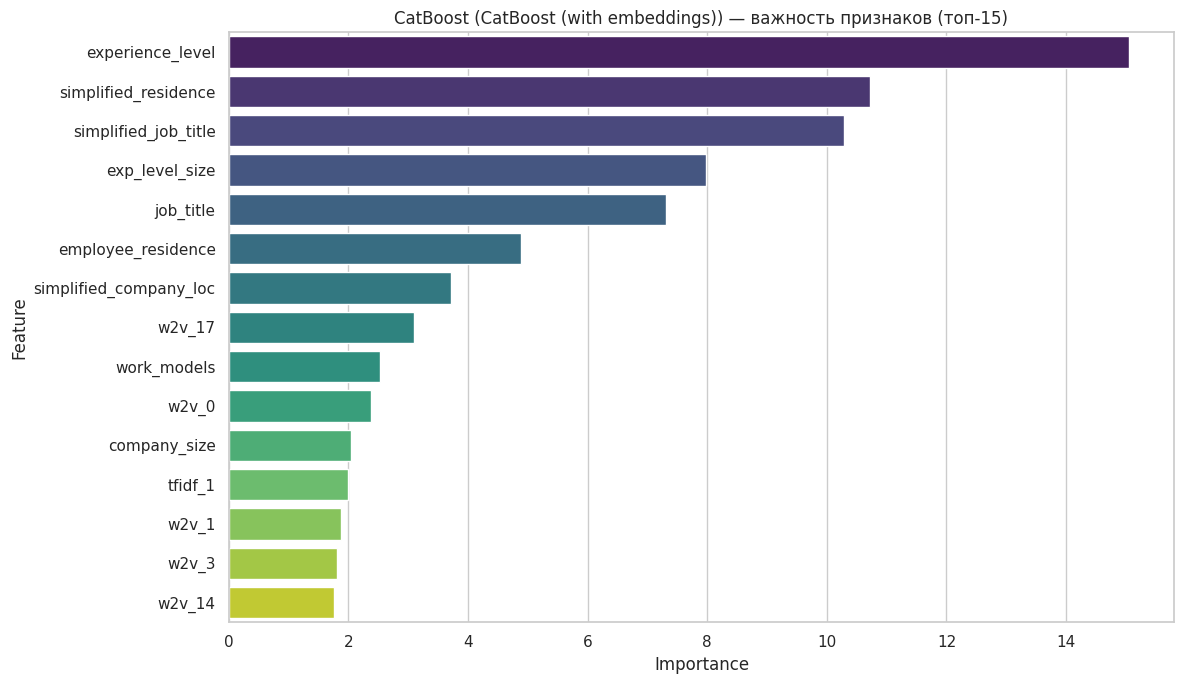

In [ ]:
# === 4.6 Важность признаков для лучшей версии CatBoost ===
print("\nВажность признаков для лучшей версии CatBoost:")

# Получаем важности
feature_importance_best = best_catboost_model.get_feature_importance()
feature_names_best = best_catboost_model.feature_names_

imp_df_best = pd.DataFrame({
    "Feature": feature_names_best,
    "Importance": feature_importance_best
}).sort_values("Importance", ascending=False)

# Печать топ-15
print("\nТоп-15 признаков по важности:")
print(imp_df_best.head(15).to_string(index=False))

# Сохраним полный список
imp_df_best.to_csv("catboost_best_feature_importance.csv", index=False)
print("\nПолный список важностей сохранён в catboost_best_feature_importance.csv")

# Визуализация (топ-15)
plt.figure(figsize=(12, 7))
sns.barplot(data=imp_df_best.head(15), x="Importance", y="Feature", palette="viridis")
plt.title(f"CatBoost ({best_model_name}) — важность признаков (топ-15)")
plt.tight_layout()
plt.savefig("catboost_best_feature_importance.png")
plt.show()



=== CatBoost с текстовыми эмбеддингами (best params из логов) ===

Категориальные признаки для CatBoost+embeddings: ['job_title', 'experience_level', 'employment_type', 'work_models', 'employee_residence', 'company_location', 'company_size', 'simplified_job_title', 'simplified_residence', 'simplified_company_loc', 'exp_level_size']

Лучшие параметры (из логов): {'iterations': 300, 'learning_rate': 0.05, 'depth': 8, 'l2_leaf_reg': 1, 'border_count': 50, 'bagging_temperature': 0.3, 'random_strength': 1.0}
0:	learn: 61180.2414561	test: 61843.2800892	best: 61843.2800892 (0)	total: 29.3ms	remaining: 8.77s
100:	learn: 46129.4529969	test: 48074.8964797	best: 48074.8964797 (100)	total: 3.63s	remaining: 7.14s
200:	learn: 44885.5340272	test: 47929.2495139	best: 47923.0334674 (177)	total: 7.87s	remaining: 3.87s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 47910.13525
bestIteration = 216

Shrink model to first 217 iterations.

[CatBoost + Embeddings (best params)] — качество 

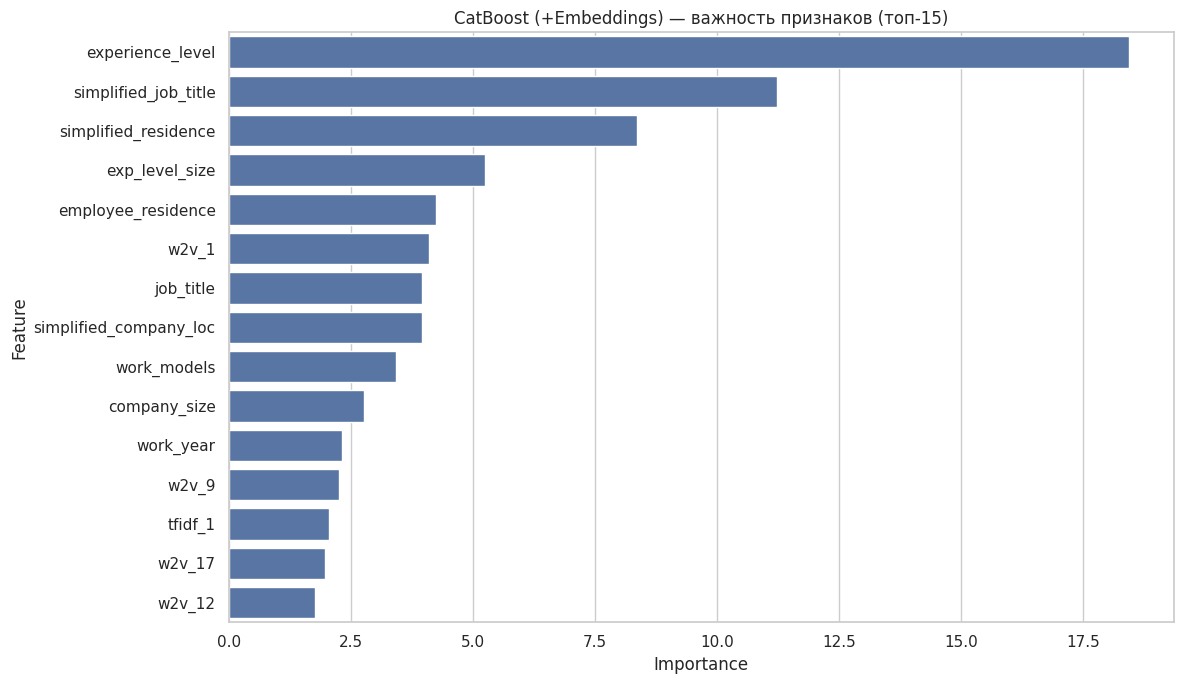

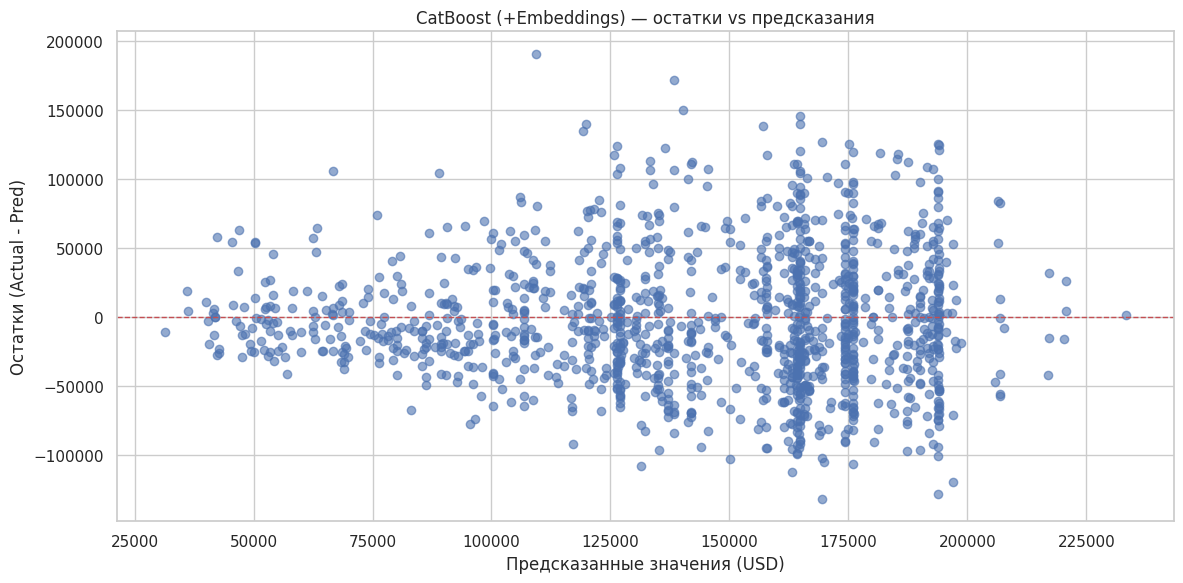

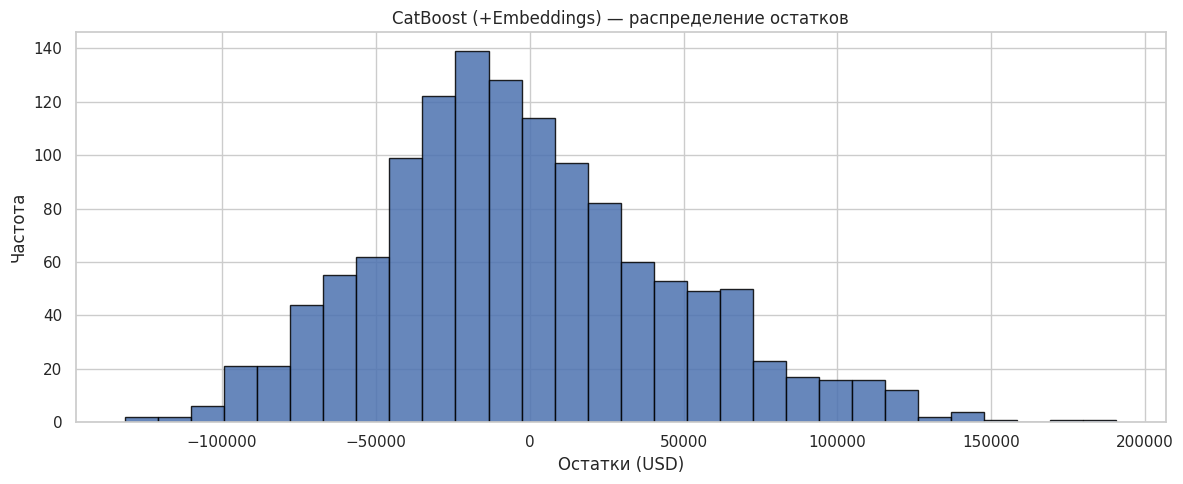


Статистика остатков:
 Среднее: -1635.58  |  STD: 47882.21  |  95-перц |resid|: 95512.77

[База vs Лучшая (+Embeddings)] — сравнение на тесте
 Base  → MAE: 37,912.77 | RMSE: 48,046.23 | R²: 0.4165
 Best  → MAE: 37,790.60 | RMSE: 47,910.14 | R²: 0.4198
 ΔR²  → +0.0033 (+0.79%)

Таблица сравнения:
     Model        MAE       RMSE     R2
      Base 37912.7661 48046.2262 0.4165
Best(+Emb) 37790.5993 47910.1353 0.4198


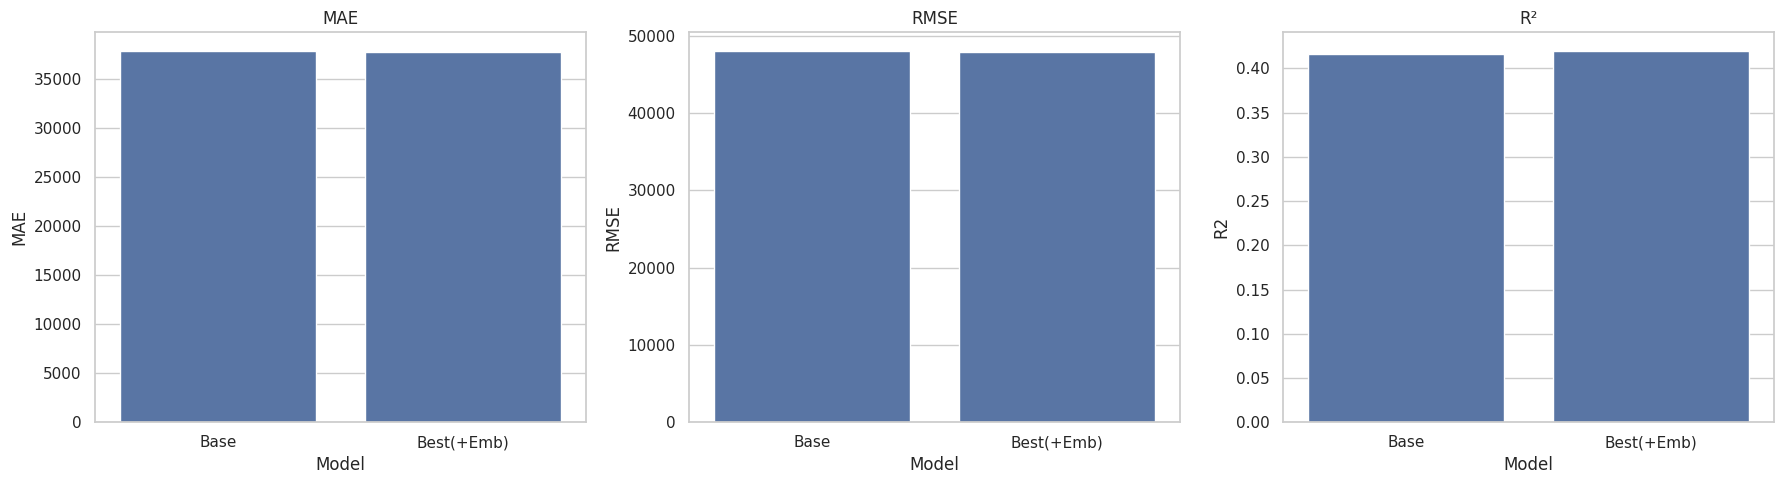


Модель CatBoost (+Embeddings, best params) сохранена: /content/artifacts/catboost_embeddings_best.pkl


In [ ]:
# === Дополнительный блок (финальный): CatBoost + текстовые эмбеддинги с уже найденными лучшими параметрами ===
# Лучшие гиперпараметры из сводки:
# {'iterations': 300, 'learning_rate': 0.05, 'depth': 8, 'l2_leaf_reg': 1,
#  'border_count': 50, 'bagging_temperature': 0.3, 'random_strength': 1.0}
# → mean_r2=0.4052 ± 0.0077 (CV, 3-fold)

import re, time, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from catboost import CatBoostRegressor

# 0) Хелпер сохранения (если ранее уже объявлен save_and_show — используем его)
def _save_and_show_default(path):
    plt.savefig(path, bbox_inches="tight", dpi=150)
    plt.show()

_save_and_show = save_and_show if "save_and_show" in globals() else _save_and_show_default
FIG_DIR = FIG_DIR if "FIG_DIR" in globals() else Path("figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

print("\n=== CatBoost с текстовыми эмбеддингами (best params из логов) ===")

# 1) Подготовка данных с текстовыми эмбеддингами (TF-IDF + Word2Vec) поверх df_fe
df_with_embeddings = df_fe.copy()
df_with_embeddings["job_title_original"] = df_clean["job_title"].copy()

def preprocess_text(text: str) -> str:
    text = str(text).lower()
    return re.sub(r"[^\w\s]", "", text)

df_with_embeddings["job_title_clean"] = df_with_embeddings["job_title_original"].apply(preprocess_text)

# TF-IDF (50 фич)
tfidf = TfidfVectorizer(max_features=50)
tfidf_matrix = tfidf.fit_transform(df_with_embeddings["job_title_clean"])
tfidf_features = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=[f"tfidf_{i}" for i in range(tfidf_matrix.shape[1])],
    index=df_with_embeddings.index
)

# Word2Vec (20 фич, усреднение по словам)
sentences = [t.split() for t in df_with_embeddings["job_title_clean"]]
w2v = Word2Vec(sentences, vector_size=20, window=5, min_count=1, workers=4)
def get_w2v_vec(s: str) -> np.ndarray:
    words = s.split()
    vecs = [w2v.wv[w] for w in words if w in w2v.wv]
    return np.mean(vecs, axis=0) if len(vecs) else np.zeros(w2v.vector_size)

w2v_emb = np.array(df_with_embeddings["job_title_clean"].apply(get_w2v_vec).tolist())
w2v_features = pd.DataFrame(
    w2v_emb,
    columns=[f"w2v_{i}" for i in range(w2v_emb.shape[1])],
    index=df_with_embeddings.index
)

# Добавляем эмбеддинги в датасет
df_with_embeddings = pd.concat([df_with_embeddings, tfidf_features, w2v_features], axis=1)
# Удаляем временные текстовые колонки
df_with_embeddings = df_with_embeddings.drop(columns=["job_title_original", "job_title_clean"])

# 2) Трейн/тест
X_with_embeddings = df_with_embeddings.drop(columns=["salary_in_usd"])
y_with_embeddings = df_with_embeddings["salary_in_usd"]

X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(
    X_with_embeddings, y_with_embeddings, test_size=0.2, random_state=42
)

# 3) Список категориальных фич (которые остаются категориальными)
categorical_features_emb = [
    "job_title", "experience_level", "employment_type", "work_models",
    "employee_residence", "company_location", "company_size",
    "simplified_job_title", "simplified_residence", "simplified_company_loc", "exp_level_size"
]
# оставляем только те, что реально есть
categorical_features_emb = [c for c in categorical_features_emb if c in X_train_emb.columns]

# приведение типов категориальных к str (если вдруг numeric)
for c in categorical_features_emb:
    if np.issubdtype(X_train_emb[c].dtype, np.number):
        X_train_emb[c] = X_train_emb[c].astype(str)
        X_test_emb[c]  = X_test_emb[c].astype(str)

print("\nКатегориальные признаки для CatBoost+embeddings:", categorical_features_emb)

# 4) Обучаем финальную модель с ЛУЧШИМИ ПАРАМЕТРАМИ (из логов)
best_params = {
    "iterations": 300,
    "learning_rate": 0.05,
    "depth": 8,
    "l2_leaf_reg": 1,
    "border_count": 50,
    "bagging_temperature": 0.3,
    "random_strength": 1.0,
    "verbose": 100,
    "random_state": 42
}
print("\nЛучшие параметры (из логов):", {k: v for k, v in best_params.items() if k not in ("verbose","random_state")})

cb_emb_best = CatBoostRegressor(**best_params)
cb_emb_best.fit(
    X_train_emb, y_train_emb,
    eval_set=(X_test_emb, y_test_emb),
    use_best_model=True,
    early_stopping_rounds=50,
    cat_features=categorical_features_emb
)

# 5) Оценка на тесте
pred_final = cb_emb_best.predict(X_test_emb)
mae_final = mean_absolute_error(y_test_emb, pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test_emb, pred_final))

r2_final = r2_score(y_test_emb, pred_final)

print("\n[CatBoost + Embeddings (best params)] — качество на тесте")
print(f" MAE : {mae_final:,.2f}")
print(f" RMSE: {rmse_final:,.2f}")
print(f" R²  : {r2_final:.4f}")

# 6) Важность признаков (печать, CSV, график)
fi_vals = cb_emb_best.get_feature_importance()
fi_names = cb_emb_best.feature_names_
fi_df = pd.DataFrame({"Feature": fi_names, "Importance": fi_vals}).sort_values("Importance", ascending=False)

print("\nТоп-15 важных признаков (CatBoost + Embeddings):")
print(fi_df.head(15).to_string(index=False))

fi_csv = Path("catboost_embeddings_best_feature_importance.csv")
fi_df.to_csv(fi_csv, index=False)
print(f"\nПолный список важностей сохранён: {fi_csv}")

plt.figure(figsize=(12, 7))
sns.barplot(data=fi_df.head(15), x="Importance", y="Feature")
plt.title("CatBoost (+Embeddings) — важность признаков (топ-15)")
plt.tight_layout()
_save_and_show(FIG_DIR / "cb_embeddings_feature_importance_top15.png")

# 7) Анализ остатков (scatter + hist)
residuals = y_test_emb.values - pred_final

plt.figure(figsize=(12, 6))
plt.scatter(pred_final, residuals, alpha=0.6)
plt.axhline(0, color="r", ls="--", lw=1)
plt.title("CatBoost (+Embeddings) — остатки vs предсказания")
plt.xlabel("Предсказанные значения (USD)")
plt.ylabel("Остатки (Actual - Pred)")
plt.tight_layout()
_save_and_show(FIG_DIR / "cb_embeddings_residuals_scatter.png")

plt.figure(figsize=(12, 5))
plt.hist(residuals, bins="auto", edgecolor="black", alpha=0.85)
plt.title("CatBoost (+Embeddings) — распределение остатков")
plt.xlabel("Остатки (USD)")
plt.ylabel("Частота")
plt.tight_layout()
_save_and_show(FIG_DIR / "cb_embeddings_residuals_hist.png")

print("\nСтатистика остатков:")
print(f" Среднее: {np.mean(residuals):.2f}  |  STD: {np.std(residuals):.2f}  |  95-перц |resid|: {np.percentile(np.abs(residuals),95):.2f}")

# 8) Сравнение с базовой моделью (та же выборка, без тюнинга)
base_cb = CatBoostRegressor(
    iterations=400, learning_rate=0.05, depth=6,
    verbose=0, random_state=42
)
base_cb.fit(X_train_emb, y_train_emb, cat_features=categorical_features_emb)
base_pred = base_cb.predict(X_test_emb)

base_mae = mean_absolute_error(y_test_emb, base_pred)
base_rmse = np.sqrt(mean_squared_error(y_test_emb, base_pred))

base_r2 = r2_score(y_test_emb, base_pred)

print("\n[База vs Лучшая (+Embeddings)] — сравнение на тесте")
print(f" Base  → MAE: {base_mae:,.2f} | RMSE: {base_rmse:,.2f} | R²: {base_r2:.4f}")
print(f" Best  → MAE: {mae_final:,.2f} | RMSE: {rmse_final:,.2f} | R²: {r2_final:.4f}")
print(f" ΔR²  → {r2_final - base_r2:+.4f} ({(r2_final - base_r2)/max(1e-9, base_r2)*100:+.2f}%)")

# Визуальное сравнение
cmp_df = pd.DataFrame({
    "Model": ["Base", "Best(+Emb)"],
    "MAE": [base_mae, mae_final],
    "RMSE": [base_rmse, rmse_final],
    "R2": [base_r2, r2_final],
})
print("\nТаблица сравнения:")
print(cmp_df.round(4).to_string(index=False))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.barplot(data=cmp_df, x="Model", y="MAE", ax=axes[0])
axes[0].set_title("MAE")
sns.barplot(data=cmp_df, x="Model", y="RMSE", ax=axes[1])
axes[1].set_title("RMSE")
sns.barplot(data=cmp_df, x="Model", y="R2", ax=axes[2])
axes[2].set_title("R²")
plt.tight_layout()
_save_and_show(FIG_DIR / "cb_embeddings_base_vs_best.png")

# 9) Сохранение лучшей модели
from pathlib import Path
ARTIFACTS_DIR = ARTIFACTS_DIR if "ARTIFACTS_DIR" in globals() else Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
model_path = ARTIFACTS_DIR / "catboost_embeddings_best.pkl"

import joblib
joblib.dump(cb_emb_best, model_path)
print(f"\nМодель CatBoost (+Embeddings, best params) сохранена: {model_path}")


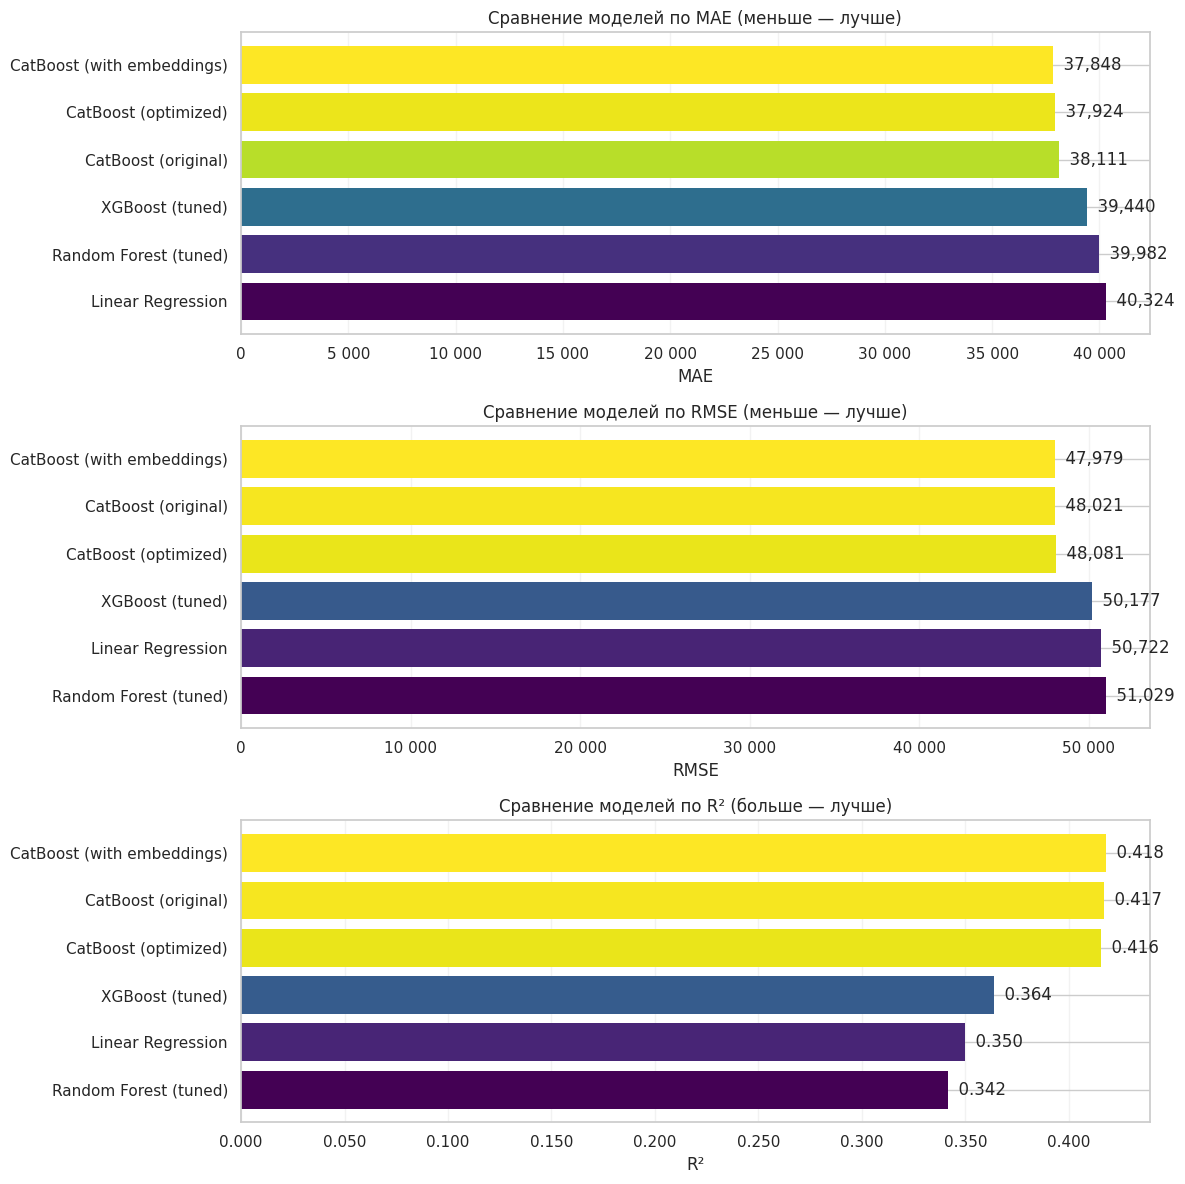

In [ ]:
# === ЛИДЕРБОРД с градиентом цвета ===
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.ticker import FuncFormatter
from pathlib import Path

def _fmt_int(x, _):
    return f"{int(x):,}".replace(",", " ")

def _fmt_float(x, _):
    return f"{x:.3f}"

def gradient_barh(ax, df, metric, better="low", title="", cmap="viridis"):
    """
    df: DataFrame с колонками ["Model", metric]
    better: "low" (меньше — лучше) или "high" (больше — лучше)
    """
    d = df.sort_values(metric, ascending=(better=="high"))  # чтобы лучший был ниже/выше аккуратно
    vals = d[metric].to_numpy(dtype=float)
    # нормируем значения для градиента
    v = vals.copy()
    if better == "low":
        # инвертируем, чтобы «лучшее» было насыщеннее
        v = v.max() - v
    norm = Normalize(vmin=v.min(), vmax=v.max() if v.max() > v.min() else v.min()+1e-9)
    colors = plt.get_cmap(cmap)(norm(v))

    bars = ax.barh(d["Model"], vals, color=colors, edgecolor="none")
    ax.set_title(title)
    ax.set_ylabel("")
    ax.grid(axis="x", alpha=.25)

    # подписи на концах полос
    for y, (bar, val) in enumerate(zip(bars, vals)):
        txt = f"{val:,.0f}" if metric in {"MAE","RMSE"} else f"{val:.3f}"
        ax.text(val, bar.get_y() + bar.get_height()/2, "  " + txt, va="center")

    # формат оси X
    if metric in {"MAE","RMSE"}:
        ax.xaxis.set_major_formatter(FuncFormatter(_fmt_int))
        ax.set_xlabel(metric)
    else:
        ax.xaxis.set_major_formatter(FuncFormatter(_fmt_float))
        ax.set_xlabel("R²")

# берём ровно нужные 6 моделей и упорядочиваем
NEEDED = [
    "Linear Regression",
    "Random Forest (tuned)",
    "XGBoost (tuned)",
    "CatBoost (optimized)",
    "CatBoost (original)",
    "CatBoost (with embeddings)",
]
lb = lb.copy()  # из предыдущего блока — таблица с метриками
lb = lb[lb["Model"].isin(NEEDED)].drop_duplicates("Model", keep="last")
lb["Model"] = pd.Categorical(lb["Model"], categories=NEEDED, ordered=True)
lb = lb.sort_values("Model")

Path("figures").mkdir(parents=True, exist_ok=True)

fig, axes = plt.subplots(3, 1, figsize=(12, 12))
gradient_barh(axes[0], lb[["Model","MAE"]],  "MAE",  better="low",
              title="Сравнение моделей по MAE (меньше — лучше)", cmap="viridis")
gradient_barh(axes[1], lb[["Model","RMSE"]], "RMSE", better="low",
              title="Сравнение моделей по RMSE (меньше — лучше)", cmap="viridis")
gradient_barh(axes[2], lb[["Model","R²"]],   "R²",   better="high",
              title="Сравнение моделей по R² (больше — лучше)", cmap="viridis")

plt.tight_layout()
plt.savefig("figures/leaderboard_6_models_gradient.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
plt.tight_layout()
plt.savefig("figures/leaderboard_6_models_gradient_blues.png",
            dpi=300, bbox_inches="tight")  # <-- сохраняем картинку
plt.show()


<Figure size 1200x700 with 0 Axes>

In [ ]:
print("\n=== Сравнение всех моделей ===")
for i, row in lb.iterrows():
    print(f"{row['Model']:<25} | "
          f"MAE: {row['MAE']:,.0f} | "
          f"RMSE: {row['RMSE']:,.0f} | "
          f"R²: {row['R²']:.4f}")

# Можно вывести в виде DataFrame (более удобно для копирования в LaTeX/Word):
print("\nТаблица результатов (округлено):")
print(lb.round({"MAE":0, "RMSE":0, "R²":3}).to_string(index=False))



=== Сравнение всех моделей ===
Linear Regression         | MAE: 40,324 | RMSE: 50,722 | R²: 0.3497
Random Forest (tuned)     | MAE: 39,982 | RMSE: 51,029 | R²: 0.3418
XGBoost (tuned)           | MAE: 39,440 | RMSE: 50,177 | R²: 0.3636
CatBoost (optimized)      | MAE: 37,924 | RMSE: 48,081 | R²: 0.4157
CatBoost (original)       | MAE: 38,111 | RMSE: 48,021 | R²: 0.4171
CatBoost (with embeddings) | MAE: 37,848 | RMSE: 47,979 | R²: 0.4182

Таблица результатов (округлено):
                     Model     MAE    RMSE    R²
         Linear Regression 40324.0 50722.0 0.350
     Random Forest (tuned) 39982.0 51029.0 0.342
           XGBoost (tuned) 39440.0 50177.0 0.364
      CatBoost (optimized) 37924.0 48081.0 0.416
       CatBoost (original) 38111.0 48021.0 0.417
CatBoost (with embeddings) 37848.0 47979.0 0.418


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path


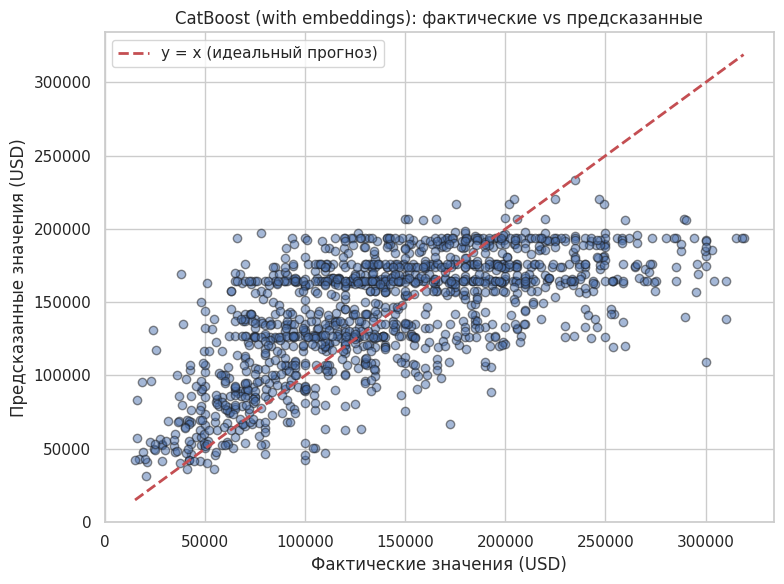

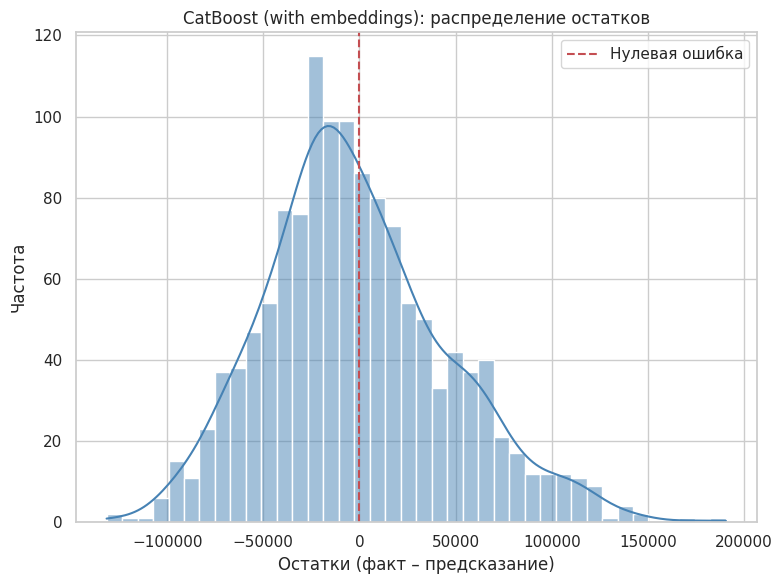

Графики сохранены в папку figures/ с подписями к красным линиям


In [ ]:
# --- 1. Предсказанные vs фактические ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test_emb, pred_final, alpha=0.5, edgecolor="k")
plt.plot([y_test_emb.min(), y_test_emb.max()],
         [y_test_emb.min(), y_test_emb.max()],
         "r--", lw=2, label="y = x (идеальный прогноз)")
plt.xlabel("Фактические значения (USD)")
plt.ylabel("Предсказанные значения (USD)")
plt.title("CatBoost (with embeddings): фактические vs предсказанные")
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig("figures/cb_embeddings_pred_vs_actual.png", dpi=300, bbox_inches="tight")
plt.show()

# --- 2. Распределение остатков ---
residuals = y_test_emb.values - pred_final
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=40, color="steelblue")
plt.axvline(0, color="r", linestyle="--", label="Нулевая ошибка")
plt.xlabel("Остатки (факт – предсказание)")
plt.ylabel("Частота")
plt.title("CatBoost (with embeddings): распределение остатков")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("figures/cb_embeddings_residuals_hist.png", dpi=300, bbox_inches="tight")
plt.show()

# --- 3. Boxplot относительных ошибок ---
relative_errors = np.abs(residuals) / y_test_emb.values * 100
plt.figure(figsize=(6, 6))
sns.boxplot(y=relative_errors, color="skyblue")
plt.ylabel("Относительная ошибка (%)")
plt.title("CatBoost (with embeddings): распределение относительных ошибок")
plt.tight_layout()
plt.savefig("figures/cb_embeddings_rel_error_box.png", dpi=300, bbox_inches="tight")
plt.show()

print("Графики сохранены в папку figures/ с подписями к красным линиям")
